In [1]:
import mujoco
from pathlib import Path
import gym_lite6
import gymnasium as gym
import gym_lite6.env, gym_lite6.scripted_policy, gym_lite6.pickup_task
import mediapy as media
import numpy as np


/media/ssd/eugene/robotic_manipulation/lerobot_venv/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [11]:
model_path = Path(gym_lite6.__path__[0] + "/../models/lite6_gripper_wide.xml").resolve()
model_spec = mujoco.MjSpec.from_file(str(model_path))
target_spec = mujoco.MjSpec.from_file(str(model_path))

obj_path = gym_lite6.__path__[0] + "/../models/cube_pickup_large.xml"
obj_spec = mujoco.MjSpec.from_file(obj_path)

scene_path = gym_lite6.__path__[0] + "/../models/scene.xml"
scene_spec = mujoco.MjSpec.from_file(scene_path)

def print_bodies(parent, level=0):
  body = parent.first_body()
  while body:
    print(''.join(['-' for i in range(level)]) + '>' + body.name)
    print_bodies(body, level + 1)
    body = parent.next_body(body)

In [13]:
# This cell is just for inspecting the xml, no need to run
print("Bodies: ")
print_bodies(scene_spec.worldbody)
print("\nSites: ")
for site in scene_spec.sites:
  print(site.name)
print("\nActuators: ")
for actuator in scene_spec.actuators:
  print(actuator.name)
# for i in range(env.unwrapped.model.njnt):
#     print(f"{i} {env.unwrapped.model.jnt(i)}")

Bodies: 
>link_base
->link1
-->link2
--->link3
---->link4
----->link5
------>link6
------->gripper_body
-------->gripper_left_finger
-------->gripper_right_finger
>target
>box

Sites: 
attachment_site
end_effector
target

Actuators: 












gripper


In [2]:
frame = scene_spec.worldbody.add_frame()
frame.attach_body(model_spec.body("link_base"), "", "-1")
# frame.attach_body(model_spec.body("target"), "", "-1")
# # frame.attach_body(obj_spec.worldbody, "", "-1")
# frame.attach_body(obj_spec.body("box"), "", "-1")
# frame.attach(model_spec)

NameError: name 'scene_spec' is not defined

In [12]:
frame = scene_spec.worldbody.add_frame()
frame.attach(model_spec)
frame.attach(obj_spec)

In [9]:
frame.childclass

''

In [70]:
# inspection of scene spec
print([(i, s.name) for i, s in enumerate(scene_spec.bodies)])
for attr in dir(scene_spec.compiler):
    if not attr.startswith("__"):
        print(attr, getattr(scene_spec.compiler, attr))
for attr in dir(scene_spec.option):
    if not attr.startswith("__"):
        print(attr, getattr(scene_spec.option, attr))

[(0, 'world'), (1, 'link_base-1'), (2, 'box-1'), (3, 'link1-1'), (4, 'link2-1'), (5, 'link3-1'), (6, 'link4-1'), (7, 'link5-1'), (8, 'link6-1'), (9, 'gripper_body-1'), (10, 'gripper_left_finger-1'), (11, 'gripper_right_finger-1')]
LRopt <MjLROpt
  accel: 20.0
  interval: 2.0
  inttotal: 10.0
  maxforce: 0.0
  mode: 1
  timeconst: 1.0
  timestep: 0.01
  tolrange: 0.05
  useexisting: 1
  uselimit: 0
>
_pybind11_conduit_v1_ <bound method PyCapsule._pybind11_conduit_v1_ of <mujoco._specs.MjsCompiler object at 0xffff22ad40b0>>
alignfree 0
autolimits 1
balanceinertia 0
boundinertia 0.0
boundmass 0.0
degree 1
discardvisual 0
eulerseq <mujoco._specs.MjCharVec object at 0xffff211f9e30>
fitaabb 0
fusestatic 0
inertiafromgeom 2
inertiagrouprange [0 5]
settotalmass -1.0
usethread 1
_pybind11_conduit_v1_ <bound method PyCapsule._pybind11_conduit_v1_ of <mujoco._specs.MjOption object at 0xffff250a5330>>
apirate 100.0
ccd_iterations 50
ccd_tolerance 1e-06
cone 0
density 0.0
disableactuator 0
disablef

In [14]:
model = scene_spec.compile()
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)


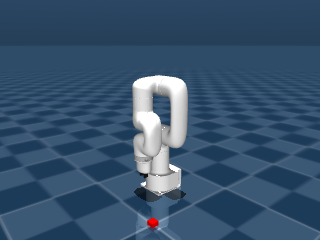

In [15]:
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 1.2
camera.elevation = -15
camera.azimuth = -130
camera.lookat = (0, 0, 0.3)

mujoco.mj_forward(model, data)

renderer.update_scene(data, camera)
media.show_image(renderer.render())


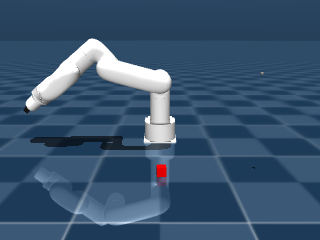

In [13]:
from importlib import reload

reload(gym_lite6.env)
reload(gym_lite6.utils)
reload(gym_lite6.scripted_policy)
reload(gym_lite6.pickup_task)

# task = gym_lite6.pickup_task.GraspTask('gripper_left_finger', 'gripper_right_finger', 'box', 'floor')
task = gym_lite6.pickup_task.GraspAndLiftTask('gripper_left_finger', 'gripper_right_finger', 'box', 'floor')

env = gym.make(
    "UfactoryCubePickup-v0",
    task=task,
    obs_type="pixels_state",
    max_episode_steps=500,
    visualization_width=320,
    visualization_height=240,
    render_fps=50
)


observation, info = env.reset()
media.show_image(env.unwrapped.render(camera="side_cam"))


# 1: Create a dataset
TODO: combine action.qpos and action.gripper into just "action"

In [72]:
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset
from lerobot.common.robot_devices.control_configs import RecordControlConfig
from PIL import Image

cfg = RecordControlConfig(
    repo_id="eufrizz/lite6_record_scripted_250413_test",
    single_task="Pick up the block",
    root="datasets/lite6_record_scripted_250413_test",
    fps=1/(int(1 / env.metadata["render_fps"] / env.unwrapped.model.opt.timestep)*env.unwrapped.model.opt.timestep), # the env is stepped at a higher rate than the renderer, sometimes they do not divide evenly
    video=True,
    # push_to_hub=False
)

""" pusht features
From pusht dataset:

{'observation.image': {'dtype': 'video',
  'shape': (96, 96, 3),
  'names': ['height', 'width', 'channel'],
  'video_info': {'video.fps': 10.0,
   'video.codec': 'av1',
   'video.pix_fmt': 'yuv420p',
   'video.is_depth_map': False,
   'has_audio': False}},
 'observation.state': {'dtype': 'float32',
  'shape': (2,),
  'names': {'motors': ['motor_0', 'motor_1']}},
 'action': {'dtype': 'float32',
  'shape': (2,),
  'names': {'motors': ['motor_0', 'motor_1']}},
 'episode_index': {'dtype': 'int64', 'shape': (1,), 'names': None},
 'frame_index': {'dtype': 'int64', 'shape': (1,), 'names': None},
 'timestamp': {'dtype': 'float32', 'shape': (1,), 'names': None},
 'next.reward': {'dtype': 'float32', 'shape': (1,), 'names': None},
 'next.done': {'dtype': 'bool', 'shape': (1,), 'names': None},
 'next.success': {'dtype': 'bool', 'shape': (1,), 'names': None},
 'index': {'dtype': 'int64', 'shape': (1,), 'names': None},
 'task_index': {'dtype': 'int64', 'shape': (1,), 'names': None}}
"""

features={'action': {'dtype': 'float32',
  'shape': (7,)},
 'observation.state.qpos': {'dtype': 'float32',
  'shape': (6,)},
 'observation.state.qvel': {'dtype': 'float32',
  'shape': (6,)},
  'observation.state.gripper': {'dtype': 'float32',
  'shape': (1,)},
 'observation.ee_pose.pos': {'dtype': 'float32',
  'shape': (3,)},
'observation.ee_pose.quat': {'dtype': 'float32',
  'shape': (4,)},
'observation.ee_pose.vel': {'dtype': 'float32',
  'shape': (3,)},
'observation.ee_pose.ang_vel': {'dtype': 'float32',
  'shape': (3,)},
 'observation.images.gripper': {'dtype': 'video',
  'shape': (240, 320, 3),
  'names': ['height', 'width', 'channels'],
  'info': None},
 'observation.images.side': {'dtype': 'video',
  'shape': (240, 320, 3),
  'names': ['height', 'width', 'channels'],
  'info': None},
   'episode_index': {'dtype': 'int64', 'shape': (1,), 'names': None},
 'frame_index': {'dtype': 'int64', 'shape': (1,), 'names': None},
 'timestamp': {'dtype': 'float32', 'shape': (1,), 'names': None},
 'reward': {'dtype': 'float32', 'shape': (1,), 'names': None},
 'index': {'dtype': 'int64', 'shape': (1,), 'names': None},
 'task_index': {'dtype': 'int64', 'shape': (1,), 'names': None}}

dataset = LeRobotDataset.create(
    cfg.repo_id,
    cfg.fps,
    root=cfg.root,
    features=features,
    use_videos=cfg.video,
    image_writer_processes=0,
    image_writer_threads=1,
)

In [73]:
reload(gym_lite6.scripted_policy)
policy = gym_lite6.scripted_policy.GraspAndLiftPolicy(env, 'end_effector', 'box', 'gripper_left_finger', 'gripper_right_finger', max_vel=0.2)
policy.reset()
observation, info = env.reset(seed=69, qpos=None, box_pos=None, box_quat=None)

step = 0
done = False
# ep_dict = {"action.qpos": [], "action.gripper": [], "observation.state.qpos": [], "observation.state.qvel": [], "observation.state.gripper": [], "observation.pixels.side": [], "observation.pixels.gripper": [], "reward": [], "timestamp": [], "frame_index": [],}
dataset.clear_episode_buffer()

while not done:
    # start_loop_t = time.perf_counter()

    action = policy(env.unwrapped.model, env.unwrapped.data, observation, info)

    # delta = action["pos"] - observation["ee_pose"]["pos"]

    # # Quaternion error
    # quat_err = np.empty(4)
    # curr_quat = observation["ee_pose"]["quat"]
    # curr_quat_conj = np.empty(4)
    # ang_delta = np.empty(3)
    # mujoco.mju_negQuat(curr_quat_conj, curr_quat)
    # mujoco.mju_mulQuat(quat_err, action["quat"], curr_quat_conj)
    # mujoco.mju_quat2Vel(ang_delta, quat_err, 1.0)
    
    # # Convert to velocity (in world frame)
    # vel = Kp * delta * env.metadata["render_fps"]
    # ang_vel = Kp * ang_delta * env.metadata["render_fps"]
    # # Transform to end effector frame
    # action["qvel"] = env.unwrapped.solve_ik_vel(vel, ang_vel, ref_frame='end_effector', local=False)
    


    obs_dict = {'task': cfg.single_task}
    obs_dict["action"] = np.hstack([action["qpos"], action["gripper"]], dtype=np.float32)
    obs_dict["observation.state.qpos"] = np.array(observation["state"]["qpos"], dtype=np.float32)
    obs_dict["observation.state.qvel"] = np.array(observation["state"]["qvel"], dtype=np.float32)
    obs_dict["observation.state.gripper"] = np.array([observation["state"]["gripper"]], dtype=np.float32)
    obs_dict["observation.images.side"] = observation["pixels"]["side"]
    obs_dict["observation.images.gripper"] = observation["pixels"]["gripper"]
    obs_dict["observation.ee_pose.pos"] = np.array(observation["ee_pose"]["pos"], dtype=np.float32)
    obs_dict["observation.ee_pose.quat"] = np.array(observation["ee_pose"]["quat"], dtype=np.float32)
    obs_dict["observation.ee_pose.vel"] = np.array(observation["ee_pose"]["vel"], dtype=np.float32)
    obs_dict["observation.ee_pose.ang_vel"] = np.array(observation["ee_pose"]["ang_vel"], dtype=np.float32)
    obs_dict["reward"] = np.array([reward], dtype=np.float32)
    obs_dict["timestamp"] = np.array([env.unwrapped.data.time], dtype=np.float32)
    dataset.add_frame(obs_dict)

    observation, reward, terminated, truncated, info = env.step(action)

    if (policy.done):
      terminated = True
    print(f"{step=} {reward=} {terminated=} {policy.stage=}")
    done = terminated | truncated | done
    step += 1
obs_dict = {'task': cfg.single_task}
obs_dict["action"] = np.hstack([action["qpos"], action["gripper"]], dtype=np.float32)
obs_dict["observation.state.qpos"] = np.array(observation["state"]["qpos"], dtype=np.float32)
obs_dict["observation.state.qvel"] = np.array(observation["state"]["qvel"], dtype=np.float32)
obs_dict["observation.state.gripper"] = np.array([observation["state"]["gripper"]], dtype=np.float32)
obs_dict["observation.images.side"] = observation["pixels"]["side"]
obs_dict["observation.images.gripper"] = observation["pixels"]["gripper"]
obs_dict["observation.ee_pose.pos"] = np.array(observation["ee_pose"]["pos"], dtype=np.float32)
obs_dict["observation.ee_pose.quat"] = np.array(observation["ee_pose"]["quat"], dtype=np.float32)
obs_dict["observation.ee_pose.vel"] = np.array(observation["ee_pose"]["vel"], dtype=np.float32)
obs_dict["observation.ee_pose.ang_vel"] = np.array(observation["ee_pose"]["ang_vel"], dtype=np.float32)
obs_dict["reward"] = np.array([reward], dtype=np.float32)
obs_dict["timestamp"] = np.array([env.unwrapped.data.time], dtype=np.float32)
dataset.add_frame(obs_dict)

dataset.image_writer.wait_until_done()
media.show_video([np.asarray(Image.open(p)) for p in dataset.episode_buffer['observation.images.side']], fps=env.metadata["render_fps"])

# if terminated:
#     print("Success!")
#     dataset.save_episode(cfg.single_task)
# else:
#     print(f"Failure! Reached {policy.stage}")
#     dataset.clear_episode_buffer()

# media.show_video(obs_dict["observation.images.gripper"], fps=env.metadata["render_fps"])

{0: {'start_time': 0.0, 'end_time': 2.721940278177479, 'T_start': array([[ 0.87216009,  0.48135745, -0.08736009, -0.13114638],
       [ 0.48575353, -0.8732822 ,  0.03770539,  0.00769468],
       [-0.05814024, -0.07532061, -0.99546297,  0.06388162],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.23304285],
       [ 0.        , -1.        ,  0.        , -0.17098923],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([ 0.23304285, -0.17098923,  0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
step=0 reward=0 terminated=False policy.stage=0
step=1 reward=0 terminated=False policy.stage=0
step=2 reward=0 terminated=False policy.stage=0
step=3 reward=0 terminated=False policy.stage=0
step=4 reward=0 terminated=False policy.stage=0
step=5 reward=0 terminated=False policy.stage=0
step=6 reward=0 terminated=False policy.stage=0
st

In [74]:
dataset.episode_buffer

{'size': 301,
 'task': ['Pick up the block',
  'Pick up the block',
  'Pick up the block',
  'Pick up the block',
  'Pick up the block',
  'Pick up the block',
  'Pick up the block',
  'Pick up the block',
  'Pick up the block',
  'Pick up the block',
  'Pick up the block',
  'Pick up the block',
  'Pick up the block',
  'Pick up the block',
  'Pick up the block',
  'Pick up the block',
  'Pick up the block',
  'Pick up the block',
  'Pick up the block',
  'Pick up the block',
  'Pick up the block',
  'Pick up the block',
  'Pick up the block',
  'Pick up the block',
  'Pick up the block',
  'Pick up the block',
  'Pick up the block',
  'Pick up the block',
  'Pick up the block',
  'Pick up the block',
  'Pick up the block',
  'Pick up the block',
  'Pick up the block',
  'Pick up the block',
  'Pick up the block',
  'Pick up the block',
  'Pick up the block',
  'Pick up the block',
  'Pick up the block',
  'Pick up the block',
  'Pick up the block',
  'Pick up the block',
  'Pick up t

In [28]:
pprint([x for x in zip((dataset.episode_buffer["timestamp"], dataset.episode_buffer["observation.images.side"]))])

[([array([0.02], dtype=float32),
   array([0.04], dtype=float32),
   array([0.06], dtype=float32),
   array([0.08], dtype=float32),
   array([0.1], dtype=float32),
   array([0.12], dtype=float32),
   array([0.14], dtype=float32),
   array([0.16], dtype=float32),
   array([0.18], dtype=float32),
   array([0.2], dtype=float32),
   array([0.22], dtype=float32),
   array([0.24], dtype=float32),
   array([0.26], dtype=float32),
   array([0.28], dtype=float32),
   array([0.3], dtype=float32),
   array([0.32], dtype=float32),
   array([0.34], dtype=float32),
   array([0.36], dtype=float32),
   array([0.38], dtype=float32),
   array([0.4], dtype=float32),
   array([0.42], dtype=float32),
   array([0.44], dtype=float32),
   array([0.46], dtype=float32),
   array([0.48], dtype=float32),
   array([0.5], dtype=float32),
   array([0.52], dtype=float32),
   array([0.54], dtype=float32),
   array([0.56], dtype=float32),
   array([0.58], dtype=float32),
   array([0.6], dtype=float32),
   array([0.62],

In [31]:
len(dataset.episode_buffer["timestamp"]), len(dataset.episode_buffer["frame_index"]), len(dataset.episode_buffer["observation.images.side"])

(461, 461, 461)

In [42]:
dataset.clear_episode_buffer()

In [78]:

import time

def record_episodes_to_lerobot(env, policy, cfg, num_ep=1):
    dataset = LeRobotDataset.create(
        cfg.repo_id,
        cfg.fps,
        root=cfg.root,
        features=features,
        use_videos=cfg.video,
        image_writer_processes=0,
        image_writer_threads=2,
    )

    successful_trajectories = 0
    while successful_trajectories < num_ep:
        step = 0
        done = False
        policy.reset()
        observation, info = env.reset(seed=69, qpos=None, box_pos=None, box_quat=None)
        reward = 0.0

        
        while not done:
            # start_loop_t = time.perf_counter()

            action = policy(env.unwrapped.model, env.unwrapped.data, observation, info)

            obs_dict = {'task': cfg.single_task}
            obs_dict["action"] = np.hstack([action["qpos"], action["gripper"]], dtype=np.float32)
            obs_dict["observation.state.qpos"] = np.array(observation["state"]["qpos"], dtype=np.float32)
            obs_dict["observation.state.qvel"] = np.array(observation["state"]["qvel"], dtype=np.float32)
            obs_dict["observation.state.gripper"] = np.array([observation["state"]["gripper"]], dtype=np.float32)
            obs_dict["observation.images.side"] = observation["pixels"]["side"]
            obs_dict["observation.images.gripper"] = observation["pixels"]["gripper"]
            obs_dict["observation.ee_pose.pos"] = np.array(observation["ee_pose"]["pos"], dtype=np.float32)
            obs_dict["observation.ee_pose.quat"] = np.array(observation["ee_pose"]["quat"], dtype=np.float32)
            obs_dict["observation.ee_pose.vel"] = np.array(observation["ee_pose"]["vel"], dtype=np.float32)
            obs_dict["observation.ee_pose.ang_vel"] = np.array(observation["ee_pose"]["ang_vel"], dtype=np.float32)
            obs_dict["reward"] = np.array([reward], dtype=np.float32)
            obs_dict["timestamp"] = np.array([env.unwrapped.data.time], dtype=np.float32)
            dataset.add_frame(obs_dict)
            observation, reward, terminated, truncated, info = env.step(action)
            # print(step)

            if (policy.done):
                terminated = True
                print(f"{step=} {reward=} {terminated=}")
            done = terminated | truncated | done
            step += 1
        
        obs_dict = {'task': cfg.single_task}
        obs_dict["action"] = np.hstack([action["qpos"], action["gripper"]], dtype=np.float32)
        obs_dict["observation.state.qpos"] = np.array(observation["state"]["qpos"], dtype=np.float32)
        obs_dict["observation.state.qvel"] = np.array(observation["state"]["qvel"], dtype=np.float32)
        obs_dict["observation.state.gripper"] = np.array([observation["state"]["gripper"]], dtype=np.float32)
        obs_dict["observation.images.side"] = observation["pixels"]["side"]
        obs_dict["observation.images.gripper"] = observation["pixels"]["gripper"]
        obs_dict["observation.ee_pose.pos"] = np.array(observation["ee_pose"]["pos"], dtype=np.float32)
        obs_dict["observation.ee_pose.quat"] = np.array(observation["ee_pose"]["quat"], dtype=np.float32)
        obs_dict["observation.ee_pose.vel"] = np.array(observation["ee_pose"]["vel"], dtype=np.float32)
        obs_dict["observation.ee_pose.ang_vel"] = np.array(observation["ee_pose"]["ang_vel"], dtype=np.float32)
        obs_dict["reward"] = np.array([reward], dtype=np.float32)
        obs_dict["timestamp"] = np.array([env.unwrapped.data.time], dtype=np.float32)
        dataset.add_frame(obs_dict)
        
        if terminated:
            print(f"Success! {successful_trajectories=}")
            successful_trajectories += 1
            dataset.save_episode()
            dataset.image_writer.wait_until_done()
            # media.show_video([np.asarray(Image.open(p)) for p in dataset.episode_buffer['observation.images.side']], fps=env.metadata["render_fps"])

        else:
            # print(f"Failure! Reached {policy.stage}")
            print("Failed, retrying", policy.done, terminated)
            dataset.clear_episode_buffer()
            time.sleep(0.1)



policy = gym_lite6.scripted_policy.GraspAndLiftPolicy(env, 'end_effector', 'box', 'gripper_left_finger', 'gripper_right_finger', max_vel=0.2)
record_episodes_to_lerobot(env, policy, cfg, num_ep=50)
# media.show_video(obs_dict["observation.images.gripper"], fps=env.metadata["render_fps"])

{0: {'start_time': 0.0, 'end_time': 6.001531415257329, 'T_start': array([[ 9.94405898e-01,  1.02053409e-01,  2.72398963e-02,
         5.23248173e-04],
       [-9.61535015e-02,  9.81348726e-01, -1.66460750e-01,
        -3.10136834e-02],
       [-4.37197245e-02,  1.62910340e-01,  9.85671754e-01,
         7.63150714e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.11282847],
       [ 0.        , -1.        ,  0.        , -0.12362678],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([ 0.11282847, -0.12362678,  0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Failed, retrying False False
{0: {'start_time': 0.0, 'end_time': 4.163164708262846, 'T_start': array([[ 0.17141534, -0.9793316 , -0.10736109,  0.04087698],
       [-0.2455804 , -0.14800838,  0.95801033,  0.27197338],
       [-0.95410012, -0.1

Map:   0%|          | 0/211 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 1.7976239195284938, 'T_start': array([[-0.11343699, -0.85623296,  0.50398131,  0.38310449],
       [-0.69990063, -0.29116115, -0.65219958, -0.11954622],
       [ 0.70517456, -0.42672039, -0.56624955,  0.35720934],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.35438669],
       [ 0.        , -1.        ,  0.        , -0.02297923],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([ 0.35438669, -0.02297923,  0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Transitioning to stage 1
Failed, retrying False False
{0: {'start_time': 0.0, 'end_time': 4.703638172875709, 'T_start': array([[-0.94685226,  0.14697356,  0.28612859,  0.15650748],
       [-0.11355872, -0.98496908,  0.13015505,  0.04925227],
       [ 0.30095716,  0.09074521,  0.94931033,  0.80355189],
       [ 0.        ,  0.        , 

Map:   0%|          | 0/257 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 2.8104037625487055, 'T_start': array([[-0.32489787, -0.19891038,  0.92459507,  0.17313489],
       [-0.19103943,  0.97128258,  0.14182413, -0.03044393],
       [-0.92625337, -0.13055576, -0.35356737,  0.35195414],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.35657975],
       [ 0.        , -1.        ,  0.        , -0.21048585],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([ 0.35657975, -0.21048585,  0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Transitioning to stage 1
Failed, retrying False False
{0: {'start_time': 0.0, 'end_time': 3.2242354727930014, 'T_start': array([[ 0.60437684, -0.7895222 , -0.10669266,  0.23211822],
       [ 0.5021072 ,  0.48144326, -0.71840152,  0.08589781],
       [ 0.61856041,  0.38061409,  0.68739794,  0.65286905],
       [ 0.        ,  0.        ,

Map:   0%|          | 0/202 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 3.6942277764433546, 'T_start': array([[ 0.25569924,  0.12863223, -0.95816055, -0.17458864],
       [ 0.15114194,  0.97360235,  0.17103972,  0.05380551],
       [ 0.95486858, -0.18855297,  0.22950766,  0.54296111],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.19909364],
       [ 0.        , -1.        ,  0.        , -0.09313264],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([ 0.19909364, -0.09313264,  0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Transitioning to stage 1
Transitioning to stage 2
Failed, retrying False False
{0: {'start_time': 0.0, 'end_time': 4.767960715320173, 'T_start': array([[ 0.87841883, -0.31678368,  0.35781064,  0.10006611],
       [ 0.40705847,  0.10371989, -0.90749413, -0.33497201],
       [ 0.25036725,  0.94280978,  0.22005898,  0.6042611 ],
       [ 

Map:   0%|          | 0/262 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 4.408015689510199, 'T_start': array([[ 0.52810594,  0.84030484, -0.12244141, -0.04718335],
       [ 0.61559348, -0.47815862, -0.62642557, -0.25069545],
       [-0.58493486,  0.25544493, -0.76980459,  0.17732539],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.25026059],
       [ 0.        , -1.        ,  0.        ,  0.21538372],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([0.25026059, 0.21538372, 0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Failed, retrying False False
{0: {'start_time': 0.0, 'end_time': 3.1219692039305817, 'T_start': array([[ 0.96889918,  0.24117966,  0.05537824, -0.13815357],
       [ 0.14636732, -0.73900294,  0.65761026, -0.0116137 ],
       [ 0.19952691, -0.62905248, -0.75132017,  0.09848581],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]),

Map:   0%|          | 0/252 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 3.464820879364834, 'T_start': array([[-5.01680070e-01,  4.16535661e-01,  7.58165648e-01,
        -4.85344646e-04],
       [ 6.46477242e-01,  7.62884261e-01,  8.64751347e-03,
         1.45491752e-01],
       [-5.74790643e-01,  4.94475123e-01, -6.52004655e-01,
         7.67236151e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.30110586],
       [ 0.        , -1.        ,  0.        , -0.22586919],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([ 0.30110586, -0.22586919,  0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Transitioning to stage 1
Failed, retrying False False
{0: {'start_time': 0.0, 'end_time': 4.8888701173988265, 'T_start': array([[-0.21890312, -0.96417339,  0.14983693,  0.02458705],
       [-0.44989197,  0.23599792,  0.86133745,  0.55367991],

Map:   0%|          | 0/238 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 5.59594251010772, 'T_start': array([[ 0.06698887,  0.01950784, -0.997563  , -0.39662574],
       [ 0.97763106,  0.19850133,  0.06953218, -0.33017838],
       [ 0.19937401, -0.97990646, -0.00577409,  0.29296515],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.31587389],
       [ 0.        , -1.        ,  0.        ,  0.04748579],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([0.31587389, 0.04748579, 0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Failed, retrying False False
{0: {'start_time': 0.0, 'end_time': 2.340104837519062, 'T_start': array([[ 0.88763683, -0.04489226, -0.4583509 ,  0.08273847],
       [-0.17609448, -0.95269576, -0.24771258,  0.04282744],
       [-0.42554858,  0.30059187, -0.85355312,  0.04579164],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), '

Map:   0%|          | 0/243 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 4.317706978924248, 'T_start': array([[-0.05363745,  0.99853625, -0.00695636,  0.01155305],
       [ 0.06624275, -0.00339291, -0.99779777, -0.17339726],
       [-0.99636084, -0.05398013, -0.0659638 ,  0.65895051],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.39922625],
       [ 0.        , -1.        ,  0.        , -0.17959885],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([ 0.39922625, -0.17959885,  0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Transitioning to stage 1
Failed, retrying False False
{0: {'start_time': 0.0, 'end_time': 1.8163503573339994, 'T_start': array([[-0.69852803, -0.68487786, -0.2073666 , -0.10486177],
       [-0.54744594,  0.69808762, -0.4614939 , -0.21421928],
       [ 0.46082701, -0.20884442, -0.86256738,  0.09948827],
       [ 0.        ,  0.        , 

Map:   0%|          | 0/182 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 2.845694891763204, 'T_start': array([[-0.99258575,  0.11256643, -0.04585117,  0.00344387],
       [ 0.06222104,  0.14651969, -0.98724897, -0.20363804],
       [-0.10441299, -0.98278216, -0.15243736,  0.3191077 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.14765459],
       [ 0.        , -1.        ,  0.        ,  0.09335721],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([0.14765459, 0.09335721, 0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Failed, retrying False False
{0: {'start_time': 0.0, 'end_time': 2.4888246568398578, 'T_start': array([[ 0.47847661, -0.81489758,  0.32711171,  0.24456671],
       [-0.83240525, -0.30232494,  0.46443636,  0.43226072],
       [-0.27957404, -0.49451144, -0.82298043,  0.18115465],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]),

Map:   0%|          | 0/261 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 3.00288140794557, 'T_start': array([[-0.01965409,  0.022182  ,  0.99956074,  0.3586014 ],
       [-0.46381671, -0.88586849,  0.01053907, -0.13474068],
       [ 0.88571315, -0.46340584,  0.02769932,  0.60092195],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.28451705],
       [ 0.        , -1.        ,  0.        ,  0.00671815],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([0.28451705, 0.00671815, 0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Transitioning to stage 1
Transitioning to stage 2
Transitioning to stage 3
Success! successful_trajectories=9


Map:   0%|          | 0/263 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 5.99813497156775, 'T_start': array([[ 0.82314236,  0.45355023, -0.34165605, -0.1112732 ],
       [-0.56676116,  0.61924287, -0.54343358, -0.12832444],
       [-0.03490635,  0.64096058,  0.76677969,  0.74770358],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.3843872 ],
       [ 0.        , -1.        ,  0.        , -0.14380182],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([ 0.3843872 , -0.14380182,  0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Transitioning to stage 1
Failed, retrying False False
{0: {'start_time': 0.0, 'end_time': 2.5722587606917, 'T_start': array([[-0.14402062,  0.10646972,  0.9838304 ,  0.21364086],
       [-0.9868178 ,  0.05870772, -0.15081127, -0.11542254],
       [-0.07381527, -0.99258128,  0.09661109,  0.43347637],
       [ 0.        ,  0.        ,  0. 

Map:   0%|          | 0/284 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 5.640245075800118, 'T_start': array([[ 0.05251847,  0.12120966, -0.99123662, -0.2491584 ],
       [-0.95237285,  0.30464987, -0.01320639,  0.03408134],
       [ 0.30037936,  0.94472042,  0.13143654,  0.58990482],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.29227993],
       [ 0.        , -1.        ,  0.        ,  0.27115861],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([0.29227993, 0.27115861, 0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Failed, retrying False False
{0: {'start_time': 0.0, 'end_time': 4.3774999066731315, 'T_start': array([[-0.2971212 , -0.29694416,  0.90749279,  0.42777242],
       [ 0.92717914,  0.13737972,  0.34851923,  0.0303629 ],
       [-0.22816185,  0.94496083,  0.234502  ,  0.58235812],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]),

Map:   0%|          | 0/242 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 3.0141464480398596, 'T_start': array([[ 0.95240873,  0.26775208, -0.14569295,  0.11189794],
       [ 0.21827696, -0.93267953, -0.28716557, -0.26391769],
       [-0.21277401,  0.24169758, -0.94673624,  0.14815551],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.28840262],
       [ 0.        , -1.        ,  0.        ,  0.25124079],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([0.28840262, 0.25124079, 0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Transitioning to stage 1
Transitioning to stage 2
Failed, retrying False False
{0: {'start_time': 0.0, 'end_time': 3.7889093232848325, 'T_start': array([[-0.11152783,  0.49586632,  0.86120737,  0.29891156],
       [-0.29883081, -0.84323845,  0.44682106,  0.27059032],
       [ 0.94776669, -0.20752231,  0.24222469,  0.47815785],
       [ 0.

Map:   0%|          | 0/189 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 4.400893924690556, 'T_start': array([[-0.82362085,  0.50266495,  0.26263403,  0.16723503],
       [ 0.11603284, -0.30393888,  0.94559904,  0.40512806],
       [ 0.55514419,  0.80928926,  0.19200476,  0.58230269],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.19255234],
       [ 0.        , -1.        ,  0.        , -0.23890331],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([ 0.19255234, -0.23890331,  0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Transitioning to stage 1
Transitioning to stage 2
Failed, retrying False False
{0: {'start_time': 0.0, 'end_time': 4.650147494747538, 'T_start': array([[ 0.93983009,  0.01692119, -0.3412229 , -0.09259594],
       [ 0.33764536, -0.19833252,  0.9201412 ,  0.26961411],
       [-0.05210571, -0.97998872, -0.19211223,  0.44485637],
       [ 0

Map:   0%|          | 0/235 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 2.4964072454449524, 'T_start': array([[ 0.27254785, -0.70523503,  0.6544931 ,  0.00781077],
       [-0.88001381, -0.45772301, -0.12674913, -0.36714289],
       [ 0.38896448, -0.54141777, -0.74536799,  0.17005254],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.       ,  0.       ,  0.       ,  0.25733  ],
       [ 0.       , -1.       ,  0.       , -0.0423154],
       [ 0.       ,  0.       , -1.       ,  0.048    ],
       [ 0.       ,  0.       ,  0.       ,  1.       ]]), 'goal_pos': array([ 0.25733  , -0.0423154,  0.048    ]), 'goal_quat': array([0, 1, 0, 0])}}
Transitioning to stage 1
Transitioning to stage 2
Failed, retrying False False
{0: {'start_time': 0.0, 'end_time': 4.616300927678176, 'T_start': array([[ 0.94483703, -0.32438587, -0.04535196, -0.03822379],
       [ 0.11223487,  0.19055909,  0.97523872,  0.27707181],
       [-0.30771143, -0.92653173,  0.21645469,  0.63949356],
       [ 0.        ,  0.    

Map:   0%|          | 0/185 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 4.6806356364752855, 'T_start': array([[ 0.50174084,  0.76440482,  0.40489679,  0.17656495],
       [-0.802753  ,  0.58584154, -0.11125337, -0.18861483],
       [-0.32224797, -0.26921175,  0.90756888,  0.74105444],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.39880279],
       [ 0.        , -1.        ,  0.        , -0.28639907],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([ 0.39880279, -0.28639907,  0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Failed, retrying False False
{0: {'start_time': 0.0, 'end_time': 1.9910080325029413, 'T_start': array([[ 0.46827566,  0.52760053, -0.70877048, -0.21844185],
       [ 0.66903984, -0.73568497, -0.10560923, -0.01043453],
       [-0.57715128, -0.42474146, -0.69748914,  0.11277973],
       [ 0.        ,  0.        ,  0.        ,  1.        

Map:   0%|          | 0/172 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 2.278462558925433, 'T_start': array([[ 0.47045809,  0.69419441,  0.54475986,  0.15344698],
       [-0.35651668, -0.41518698,  0.83696812,  0.15594026],
       [ 0.80719579, -0.58797439,  0.05216381,  0.32672317],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.11611146],
       [ 0.        , -1.        ,  0.        , -0.19741362],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([ 0.11611146, -0.19741362,  0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Transitioning to stage 1
Transitioning to stage 2
Transitioning to stage 3
Success! successful_trajectories=16


Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 6.419319449100518, 'T_start': array([[ 0.34594485, -0.87932068,  0.32728779, -0.02804142],
       [ 0.93158155,  0.28037938, -0.23139407, -0.02326531],
       [ 0.11170484,  0.38494486,  0.91615473,  0.80738744],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.2619811 ],
       [ 0.        , -1.        ,  0.        ,  0.10890034],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([0.2619811 , 0.10890034, 0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Failed, retrying False False
{0: {'start_time': 0.0, 'end_time': 4.321151585221188, 'T_start': array([[ 0.66765158, -0.530476  , -0.52233762, -0.24842905],
       [ 0.14247678, -0.59760521,  0.78903003,  0.34740977],
       [-0.73071317, -0.60121812, -0.32341155,  0.41553216],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 

Map:   0%|          | 0/281 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 4.33831877989549, 'T_start': array([[-0.19692013,  0.77291326, -0.6031812 , -0.18433155],
       [-0.72657384, -0.52811837, -0.4395241 , -0.28705354],
       [-0.65826508,  0.35170454,  0.66557569,  0.68901268],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.17824933],
       [ 0.        , -1.        ,  0.        ,  0.16196948],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([0.17824933, 0.16196948, 0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Failed, retrying False False
{0: {'start_time': 0.0, 'end_time': 2.4935709881419896, 'T_start': array([[-0.53289479, -0.84412928, -0.05889736, -0.0981695 ],
       [-0.84611983,  0.53072328,  0.04913282,  0.0947581 ],
       [-0.01021625,  0.07601685, -0.99705419,  0.01658653],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 

Map:   0%|          | 0/293 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 3.6892092159942336, 'T_start': array([[-0.91658027, -0.3276522 ,  0.22918254,  0.03157017],
       [ 0.15154769, -0.81507435, -0.55918431, -0.05844271],
       [ 0.37001878, -0.47780522,  0.79673601,  0.64614634],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.19681703],
       [ 0.        , -1.        ,  0.        , -0.06082774],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([ 0.19681703, -0.06082774,  0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Failed, retrying False False
{0: {'start_time': 0.0, 'end_time': 2.2606811121674624, 'T_start': array([[-0.39473771, -0.91308196, -0.10229108,  0.14267625],
       [-0.16576845,  0.18028062, -0.96954614, -0.28611275],
       [ 0.90371619, -0.36575979, -0.22252374,  0.27575273],
       [ 0.        ,  0.        ,  0.        ,  1.        

Map:   0%|          | 0/170 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 1.8845706236287612, 'T_start': array([[-0.56944992,  0.2508802 ,  0.78280644,  0.18676671],
       [ 0.79691887, -0.06507334,  0.6005712 ,  0.11944884],
       [ 0.20161125,  0.96582845, -0.16287516,  0.30069682],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.22890368],
       [ 0.        , -1.        ,  0.        ,  0.0824394 ],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([0.22890368, 0.0824394 , 0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Transitioning to stage 1
Transitioning to stage 2
Transitioning to stage 3
Success! successful_trajectories=20


Map:   0%|          | 0/157 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 2.2710731390660106, 'T_start': array([[-0.13673772, -0.28974661,  0.94728544,  0.20705954],
       [-0.84427784,  0.53429213,  0.04155528, -0.00963261],
       [-0.51816765, -0.79408993, -0.31768453,  0.31884021],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.24493869],
       [ 0.        , -1.        ,  0.        ,  0.08517771],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([0.24493869, 0.08517771, 0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Transitioning to stage 1
Transitioning to stage 2
Failed, retrying False False
{0: {'start_time': 0.0, 'end_time': 3.4270200877645145, 'T_start': array([[ 0.51180628,  0.7882995 , -0.34152339, -0.22338169],
       [ 0.69068289, -0.61396895, -0.38209851, -0.22036214],
       [-0.51089282, -0.04032395, -0.85869815, -0.00864579],
       [ 0.

Map:   0%|          | 0/191 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 2.53541998617069, 'T_start': array([[ 0.01947955,  0.78484466,  0.61938632,  0.146663  ],
       [ 0.69939356,  0.43200503, -0.56940346,  0.15482846],
       [-0.71447127,  0.44428652, -0.54050004,  0.04544769],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.13781068],
       [ 0.        , -1.        ,  0.        , -0.1762386 ],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([ 0.13781068, -0.1762386 ,  0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Transitioning to stage 1
Failed, retrying False False
{0: {'start_time': 0.0, 'end_time': 4.762588049907981, 'T_start': array([[ 0.33581226, -0.26898736,  0.90270479,  0.34473076],
       [-0.40264386,  0.82539147,  0.39573581,  0.15702885],
       [-0.85153276, -0.49636148,  0.16887046,  0.62600656],
       [ 0.        ,  0.        ,  0

Map:   0%|          | 0/181 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 3.5661999523765204, 'T_start': array([[ 0.40961719, -0.60013884,  0.68705686,  0.4768158 ],
       [-0.49445055, -0.77897373, -0.38564049, -0.11337102],
       [ 0.76663708, -0.18175067, -0.61582001,  0.35288102],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.22992815],
       [ 0.        , -1.        ,  0.        ,  0.26899236],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([0.22992815, 0.26899236, 0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Transitioning to stage 1
Transitioning to stage 2
Failed, retrying False False
Error writing image datasets/lite6_record_scripted_250413_test/images/observation.images.side/episode_000023/frame_000249.png: [Errno 2] No such file or directory: '/media/ssd/eugene/robotic_manipulation/lerobot_tests/datasets/lite6_record_scripted_250413_test/

Map:   0%|          | 0/256 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 4.5262962001650555, 'T_start': array([[-0.39181251,  0.542028  , -0.7434303 , -0.03361714],
       [-0.6817876 , -0.71362072, -0.16096936, -0.01797757],
       [-0.61777717,  0.44379175,  0.6491535 ,  0.60505574],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.37781382],
       [ 0.        , -1.        ,  0.        , -0.10493443],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([ 0.37781382, -0.10493443,  0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Failed, retrying False False
Error writing image datasets/lite6_record_scripted_250413_test/images/observation.images.gripper/episode_000024/frame_000300.png: [Errno 2] No such file or directory: '/media/ssd/eugene/robotic_manipulation/lerobot_tests/datasets/lite6_record_scripted_250413_test/images/observation.images.gripper/episode_00

Map:   0%|          | 0/247 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 3.06856529551408, 'T_start': array([[ 0.40892511,  0.43359755,  0.80297785,  0.26296425],
       [ 0.55379073,  0.58145917, -0.59600425, -0.19076459],
       [-0.72532481,  0.68840279, -0.00234904,  0.51847637],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.12775612],
       [ 0.        , -1.        ,  0.        , -0.08110128],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([ 0.12775612, -0.08110128,  0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Transitioning to stage 1
Transitioning to stage 2
Transitioning to stage 3
Failed, retrying False False
{0: {'start_time': 0.0, 'end_time': 4.283084061045987, 'T_start': array([[-0.74117658,  0.23527956, -0.62872951, -0.14371898],
       [-0.16868425, -0.97179448, -0.16480626, -0.02501544],
       [-0.64977142, -0.01609377,  0.75995927, 

Map:   0%|          | 0/230 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 4.640225511901604, 'T_start': array([[ 0.21722309,  0.09329888, -0.97165294, -0.51775135],
       [ 0.61590463, -0.78535502,  0.06228146,  0.0745981 ],
       [-0.75728173, -0.61197452, -0.22806046,  0.38315572],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.15618846],
       [ 0.        , -1.        ,  0.        ,  0.27315068],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([0.15618846, 0.27315068, 0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Transitioning to stage 1
Failed, retrying False False
{0: {'start_time': 0.0, 'end_time': 5.196015817582112, 'T_start': array([[ 0.17277921,  0.42698846, -0.88759687, -0.47646266],
       [ 0.97099281,  0.07738502,  0.22623996, -0.08806986],
       [ 0.16528856, -0.90093974, -0.4012322 ,  0.27440425],
       [ 0.        ,  0.        ,  0. 

Map:   0%|          | 0/262 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 5.322281929408497, 'T_start': array([[-0.82530656, -0.00381406, -0.56467206, -0.21626026],
       [-0.00899624, -0.99976147,  0.01990146,  0.16773321],
       [-0.56461328,  0.02150473,  0.82507539,  0.71653482],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.34629336],
       [ 0.        , -1.        ,  0.        , -0.14327455],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([ 0.34629336, -0.14327455,  0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Failed, retrying False False
Error writing image datasets/lite6_record_scripted_250413_test/images/observation.images.gripper/episode_000027/frame_000300.png: [Errno 2] No such file or directory: '/media/ssd/eugene/robotic_manipulation/lerobot_tests/datasets/lite6_record_scripted_250413_test/images/observation.images.gripper/episode_000

Map:   0%|          | 0/292 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 3.3801844558367815, 'T_start': array([[-0.05294074,  0.99734052,  0.05009147, -0.1354039 ],
       [ 0.99824113,  0.05419551, -0.02403104,  0.08585071],
       [-0.02668186,  0.04873114, -0.99845548,  0.0369147 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.28635949],
       [ 0.        , -1.        ,  0.        ,  0.22593963],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([0.28635949, 0.22593963, 0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Transitioning to stage 1
Failed, retrying False False
Error writing image datasets/lite6_record_scripted_250413_test/images/observation.images.side/episode_000028/frame_000252.png: [Errno 2] No such file or directory: '/media/ssd/eugene/robotic_manipulation/lerobot_tests/datasets/lite6_record_scripted_250413_test/images/observation.images

Map:   0%|          | 0/261 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 3.996269688060201, 'T_start': array([[ 0.35892527,  0.85971149,  0.36341273,  0.25550859],
       [ 0.083005  ,  0.35841368, -0.92986548, -0.25672859],
       [-0.92966812,  0.36391729,  0.05728337,  0.56311716],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.17198072],
       [ 0.        , -1.        ,  0.        ,  0.14877021],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([0.17198072, 0.14877021, 0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Transitioning to stage 1
Failed, retrying False False
{0: {'start_time': 0.0, 'end_time': 3.682947448281813, 'T_start': array([[-0.66763353,  0.51562969,  0.53702094,  0.14883641],
       [ 0.26144372, -0.51300523,  0.81760187,  0.15422385],
       [ 0.69707435,  0.68625917,  0.20769135,  0.68771643],
       [ 0.        ,  0.        ,  0. 

Map:   0%|          | 0/282 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 6.908333730967399, 'T_start': array([[-0.63530612, -0.14315107, -0.75887674, -0.281065  ],
       [-0.27495791, -0.87634557,  0.39549538,  0.17064329],
       [-0.72165385,  0.4599198 ,  0.51738718,  0.65866409],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.37085766],
       [ 0.        , -1.        ,  0.        ,  0.27514538],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([0.37085766, 0.27514538, 0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Failed, retrying False False
{0: {'start_time': 0.0, 'end_time': 3.636292696305821, 'T_start': array([[ 2.54899272e-01, -5.98559591e-04,  9.66967426e-01,
         2.39388192e-01],
       [-1.68035129e-01,  9.84757714e-01,  4.49047891e-02,
         1.31887375e-02],
       [-9.52255510e-01, -1.73930694e-01,  2.50913446e-01,
         6.272877

Map:   0%|          | 0/199 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 5.031799359078369, 'T_start': array([[ 0.61598705, -0.77362453,  0.14854308,  0.01631359],
       [-0.77418137, -0.55965691,  0.29568116,  0.3577121 ],
       [-0.14561304, -0.29713505, -0.94366711,  0.13986138],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.15000468],
       [ 0.        , -1.        ,  0.        , -0.24212746],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([ 0.15000468, -0.24212746,  0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Transitioning to stage 1
Transitioning to stage 2
Transitioning to stage 3
Success! successful_trajectories=31


Map:   0%|          | 0/296 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 4.644428141199531, 'T_start': array([[-0.95703427,  0.14269605, -0.25243461,  0.00861241],
       [-0.22876683, -0.90648898,  0.35488516,  0.0075116 ],
       [-0.17818848,  0.39738592,  0.90018514,  0.76624403],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.3965019 ],
       [ 0.        , -1.        ,  0.        , -0.08297763],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([ 0.3965019 , -0.08297763,  0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Failed, retrying False False
{0: {'start_time': 0.0, 'end_time': 3.869429594267255, 'T_start': array([[ 0.98192821,  0.17549194, -0.07084888,  0.00790562],
       [ 0.00283297, -0.38794704, -0.92167731, -0.36930808],
       [-0.18923255,  0.90482024, -0.38143331,  0.32152634],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]

Map:   0%|          | 0/189 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 5.853632834842228, 'T_start': array([[ 0.10649375, -0.89633769, -0.43039263, -0.15124861],
       [ 0.18003219, -0.40831779,  0.8949106 ,  0.28492262],
       [-0.97787908, -0.17278691,  0.11788634,  0.57648131],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.37348315],
       [ 0.        , -1.        ,  0.        , -0.27065453],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([ 0.37348315, -0.27065453,  0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Failed, retrying False False
{0: {'start_time': 0.0, 'end_time': 2.5678008690833902, 'T_start': array([[ 0.88498541,  0.32203733,  0.33629269,  0.25203343],
       [ 0.00737472, -0.73185296,  0.68142267,  0.14029089],
       [ 0.46556034, -0.60056906, -0.65005413,  0.41705894],
       [ 0.        ,  0.        ,  0.        ,  1.        ]

Map:   0%|          | 0/197 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 4.035625483434282, 'T_start': array([[-0.73863811,  0.54175906, -0.40113697, -0.43984681],
       [ 0.64447896,  0.74200429, -0.18459823, -0.06365209],
       [ 0.19763759, -0.39487563, -0.89722496,  0.17009575],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.11275288],
       [ 0.        , -1.        ,  0.        , -0.28470126],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([ 0.11275288, -0.28470126,  0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Failed, retrying False False
Error writing image datasets/lite6_record_scripted_250413_test/images/observation.images.side/episode_000034/frame_000244.png: [Errno 2] No such file or directory: '/media/ssd/eugene/robotic_manipulation/lerobot_tests/datasets/lite6_record_scripted_250413_test/images/observation.images.side/episode_000034/fr

Map:   0%|          | 0/156 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

[image2 @ 0xaaaadcf30300] Could not open file : datasets/lite6_record_scripted_250413_test/images/observation.images.gripper/episode_000034/frame_000156.png
Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop s

{0: {'start_time': 0.0, 'end_time': 4.815235403504637, 'T_start': array([[-0.96366494, -0.02168799,  0.26623206,  0.11445308],
       [-0.17139097, -0.71426948, -0.67856042, -0.35971684],
       [ 0.20487805, -0.69953466,  0.68459934,  0.63973365],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.33716229],
       [ 0.        , -1.        ,  0.        , -0.27042311],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([ 0.33716229, -0.27042311,  0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Transitioning to stage 1
Transitioning to stage 2
Failed, retrying False False
{0: {'start_time': 0.0, 'end_time': 3.85608389679002, 'T_start': array([[ 0.61031311,  0.41811726, -0.67282677, -0.49899019],
       [-0.24632355, -0.70708225, -0.66284191, -0.22785919],
       [-0.75288951,  0.57027418, -0.32854944,  0.22335831],
       [ 0.

Map:   0%|          | 0/176 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 1.6674400583741333, 'T_start': array([[-0.85288824, -0.10431343,  0.51156657,  0.27818456],
       [ 0.24158461,  0.78977786,  0.5638154 ,  0.28567948],
       [-0.46283747,  0.60445813, -0.64839173,  0.30240527],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.24706542],
       [ 0.        , -1.        ,  0.        ,  0.29092729],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([0.24706542, 0.29092729, 0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Failed, retrying False False
{0: {'start_time': 0.0, 'end_time': 2.4141449596434694, 'T_start': array([[-0.97412869, -0.22590161, -0.0064618 ,  0.00591619],
       [-0.21251591,  0.90593124,  0.36623159,  0.15875342],
       [-0.07687836,  0.35812993, -0.9305013 ,  0.21063036],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

Map:   0%|          | 0/269 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 2.8758376727532795, 'T_start': array([[-0.48908997, -0.67434758, -0.55321455, -0.1627862 ],
       [-0.56674063,  0.72781228, -0.38612737, -0.30530006],
       [ 0.6630204 ,  0.12467814, -0.73814586,  0.17946629],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.15769526],
       [ 0.        , -1.        ,  0.        , -0.25937334],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([ 0.15769526, -0.25937334,  0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Transitioning to stage 1
Failed, retrying False False
Error writing image datasets/lite6_record_scripted_250413_test/images/observation.images.gripper/episode_000037/frame_000239.png: [Errno 2] No such file or directory: '/media/ssd/eugene/robotic_manipulation/lerobot_tests/datasets/lite6_record_scripted_250413_test/images/observation.

Map:   0%|          | 0/282 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 3.248152155785724, 'T_start': array([[-0.0157357 , -0.99641777, -0.08309035, -0.20831865],
       [-0.74649373,  0.06699334, -0.66201133, -0.09460883],
       [ 0.66520636,  0.05160921, -0.74487381,  0.17342852],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.23009633],
       [ 0.        , -1.        ,  0.        , -0.1728881 ],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([ 0.23009633, -0.1728881 ,  0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Transitioning to stage 1
Failed, retrying False False
Error writing image datasets/lite6_record_scripted_250413_test/images/observation.images.gripper/episode_000038/frame_000271.png: [Errno 2] No such file or directory: '/media/ssd/eugene/robotic_manipulation/lerobot_tests/datasets/lite6_record_scripted_250413_test/images/observation.i

Map:   0%|          | 0/280 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 0.9490938622189301, 'T_start': array([[-0.58487822,  0.78112683, -0.21853681,  0.04999335],
       [ 0.75595028,  0.622607  ,  0.20223676, -0.09292518],
       [ 0.29403511, -0.04691909, -0.95464232,  0.03913774],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.16837576],
       [ 0.        , -1.        ,  0.        , -0.05287962],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([ 0.16837576, -0.05287962,  0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Transitioning to stage 1
Transitioning to stage 2
Transitioning to stage 3
Success! successful_trajectories=39


Map:   0%|          | 0/133 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 5.5156140007542165, 'T_start': array([[ 0.57749795,  0.73684973, -0.35149479,  0.06955695],
       [-0.81504582,  0.54508787, -0.19641669,  0.05891541],
       [ 0.04686596,  0.3999146 ,  0.91535343,  0.73050337],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.1774558 ],
       [ 0.        , -1.        ,  0.        , -0.01617446],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([ 0.1774558 , -0.01617446,  0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Failed, retrying False False
{0: {'start_time': 0.0, 'end_time': 3.783410979857799, 'T_start': array([[-0.94123044,  0.03185413, -0.33625967,  0.12997444],
       [ 0.16288404, -0.82932772, -0.53449446,  0.03966005],
       [-0.29589532, -0.55785379,  0.77539996,  0.68190233],
       [ 0.        ,  0.        ,  0.        ,  1.        ]

Map:   0%|          | 0/275 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 3.3854479359303067, 'T_start': array([[-0.90206024,  0.42490091, -0.07580587,  0.28548815],
       [-0.41547263, -0.80725768,  0.41918674,  0.14525511],
       [ 0.11691796,  0.40962696,  0.90472976,  0.67814848],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.33077639],
       [ 0.        , -1.        ,  0.        , -0.04690245],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([ 0.33077639, -0.04690245,  0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Transitioning to stage 1
Transitioning to stage 2
Failed, retrying False False
{0: {'start_time': 0.0, 'end_time': 6.26099313114753, 'T_start': array([[ 3.09839408e-01,  9.46590829e-01, -8.92487751e-02,
        -4.40909118e-04],
       [ 1.03907578e-01,  5.95944037e-02,  9.92799941e-01,
         4.00629319e-01],
       [ 9.45094046e-01

Map:   0%|          | 0/244 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 5.018538167322773, 'T_start': array([[-0.26751012,  0.21341478, -0.93962358, -0.15620407],
       [-0.40989295,  0.85732501,  0.31141869,  0.05028936],
       [ 0.87202414,  0.46845273, -0.1418659 ,  0.65136199],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.17006558],
       [ 0.        , -1.        ,  0.        , -0.28549206],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([ 0.17006558, -0.28549206,  0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Transitioning to stage 1
Failed, retrying False False
{0: {'start_time': 0.0, 'end_time': 0.8698783410771261, 'T_start': array([[ 0.38051195,  0.81907685,  0.42932943,  0.23255917],
       [ 0.92345684, -0.36132798, -0.12911061, -0.15374028],
       [ 0.04937722,  0.44559533, -0.89387174,  0.09379888],
       [ 0.        ,  0.        , 

Map:   0%|          | 0/224 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 1.8147960435563417, 'T_start': array([[-0.64277684, -0.09953541,  0.7595595 ,  0.32318913],
       [-0.31476751,  0.93827121, -0.14341741, -0.03941161],
       [-0.6983977 , -0.33127004, -0.63442952,  0.4038761 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.37777844],
       [ 0.        , -1.        ,  0.        , -0.07733925],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([ 0.37777844, -0.07733925,  0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Transitioning to stage 1
Transitioning to stage 2
Failed, retrying False False
{0: {'start_time': 0.0, 'end_time': 2.669539936718728, 'T_start': array([[ 0.23648295,  0.84955888,  0.47151407,  0.19006002],
       [ 0.95069281, -0.30252623,  0.06827198,  0.24390014],
       [ 0.20064644,  0.43211988, -0.87921182,  0.11915469],
       [ 

Map:   0%|          | 0/215 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 5.174961345282122, 'T_start': array([[-0.80942926, -0.34801481, -0.47297989, -0.18365316],
       [ 0.57728849, -0.3241063 , -0.74946188, -0.153521  ],
       [ 0.10752807, -0.87968221,  0.46324606,  0.55379824],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.23694417],
       [ 0.        , -1.        ,  0.        ,  0.21558844],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([0.23694417, 0.21558844, 0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Transitioning to stage 1
Failed, retrying False False
{0: {'start_time': 0.0, 'end_time': 1.055259956742045, 'T_start': array([[-0.60681862,  0.48346322,  0.63089974,  0.10082304],
       [ 0.77092307,  0.55124218,  0.3190763 ,  0.12602683],
       [-0.19351689,  0.6799966 , -0.70721697,  0.17398985],
       [ 0.        ,  0.        ,  0. 

Map:   0%|          | 0/245 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 5.049197794059361, 'T_start': array([[ 0.06011675, -0.9577164 ,  0.28136323,  0.21546153],
       [ 0.99790983,  0.06435687,  0.00584488,  0.10037708],
       [-0.02370539,  0.28042376,  0.95958354,  0.74830734],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.2191772 ],
       [ 0.        , -1.        ,  0.        , -0.02395445],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([ 0.2191772 , -0.02395445,  0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Failed, retrying False False
{0: {'start_time': 0.0, 'end_time': 4.04810122471351, 'T_start': array([[-0.66411056,  0.71515449, -0.2179707 , -0.30212539],
       [-0.65638618, -0.69730482, -0.28796383, -0.21697745],
       [-0.35793064, -0.04816686,  0.93250502,  0.67342501],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

Map:   0%|          | 0/145 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 4.159408372565567, 'T_start': array([[ 0.18782499, -0.94198553,  0.27818166,  0.03820228],
       [ 0.79517301,  0.31208705,  0.51990534,  0.25250241],
       [-0.5765602 ,  0.12355133,  0.80765921,  0.69970697],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.39771777],
       [ 0.        , -1.        ,  0.        ,  0.11456681],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([0.39771777, 0.11456681, 0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Failed, retrying False False
{0: {'start_time': 0.0, 'end_time': 5.086039733703141, 'T_start': array([[ 0.99657248, -0.07706053,  0.0300826 ,  0.18658   ],
       [ 0.07640201,  0.99682409,  0.02246019,  0.10481413],
       [-0.03171785, -0.02008484,  0.99929504,  0.77189727],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 

Map:   0%|          | 0/180 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 3.994277339670459, 'T_start': array([[ 0.70783618,  0.70042632, -0.0914927 ,  0.00410072],
       [-0.37165157,  0.25913526, -0.89147295, -0.09389848],
       [-0.60070214,  0.66502021,  0.44373985,  0.6088891 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.26020071],
       [ 0.        , -1.        ,  0.        ,  0.20369029],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([0.26020071, 0.20369029, 0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Failed, retrying False False
Error writing image datasets/lite6_record_scripted_250413_test/images/observation.images.gripper/episode_000047/frame_000300.png: [Errno 2] No such file or directory: '/media/ssd/eugene/robotic_manipulation/lerobot_tests/datasets/lite6_record_scripted_250413_test/images/observation.images.gripper/episode_000047

Map:   0%|          | 0/191 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 2.8516358055845217, 'T_start': array([[ 0.20432908, -0.96007904,  0.19104412,  0.14260779],
       [-0.38702465,  0.10002918,  0.91662756,  0.21025058],
       [-0.8991449 , -0.26123245, -0.35113538,  0.34605049],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.21594742],
       [ 0.        , -1.        ,  0.        ,  0.03690418],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([0.21594742, 0.03690418, 0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Transitioning to stage 1
Transitioning to stage 2
Failed, retrying False False
Error writing image datasets/lite6_record_scripted_250413_test/images/observation.images.gripper/episode_000048/frame_000238.png: [Errno 2] No such file or directory: '/media/ssd/eugene/robotic_manipulation/lerobot_tests/datasets/lite6_record_scripted_250413_te

Map:   0%|          | 0/158 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

{0: {'start_time': 0.0, 'end_time': 4.638325995664814, 'T_start': array([[-5.99604317e-01, -8.00295938e-01,  1.03650363e-03,
        -1.19563300e-04],
       [ 2.36089282e-01, -1.78121971e-01, -9.55266672e-01,
        -1.88917584e-01],
       [ 7.64680661e-01, -5.72537313e-01,  2.95743996e-01,
         5.82130479e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.26591179],
       [ 0.        , -1.        ,  0.        ,  0.03018088],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([0.26591179, 0.03018088, 0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
Transitioning to stage 1
Failed, retrying False False
{0: {'start_time': 0.0, 'end_time': 4.431446449362328, 'T_start': array([[-0.0617029 , -0.9932421 , -0.09830001, -0.36627906],
       [-0.93258316,  0.09246589, -0.34891074, -0.16440938],
   

Map:   0%|          | 0/221 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Svt[info]: -------------------------------------------
Svt[info]: SVT [version]:	SVT-AV1 Encoder Lib v2.3.0
Svt[info]: SVT [build]  :	GCC 11.4.0	 64 bit
Svt[info]: LIB Build date: Feb 13 2025 18:13:05
Svt[info]: -------------------------------------------
Svt[info]: Level of Parallelism: 5
Svt[info]: Number of PPCS 76
Svt[info]: [asm level on system : up to neon_dotprod]
Svt[info]: [asm level selected : up to neon_dotprod]
Svt[info]: -------------------------------------------
Svt[info]: SVT [config]: main profile	tier (auto)	level (auto)
Svt[info]: SVT [config]: width / height / fps numerator / fps denominator 		: 320 / 240 / 125 / 4
Svt[info]: SVT [config]: bit-depth / color format 					: 8 / YUV420
Svt[info]: SVT [config]: preset / tune / pred struct 					: 10 / PSNR / random access
Svt[info]: SVT [config]: gop size / mini-gop size / key-frame type 			: 2 / 16 / key frame
Svt[info]: SVT [config]: BRC mode / rate factor 					: CRF / 30 
Svt[info]: SVT [config]: AQ mode / variance boo

In [79]:
dataset.encode_videos()

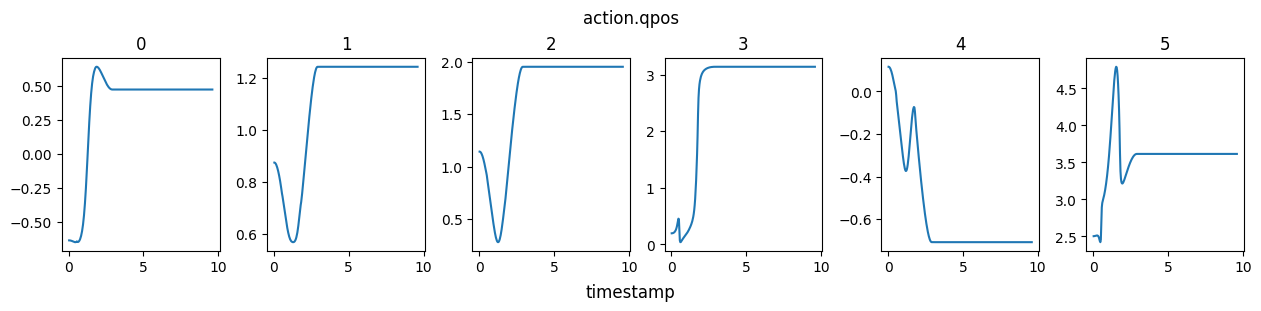

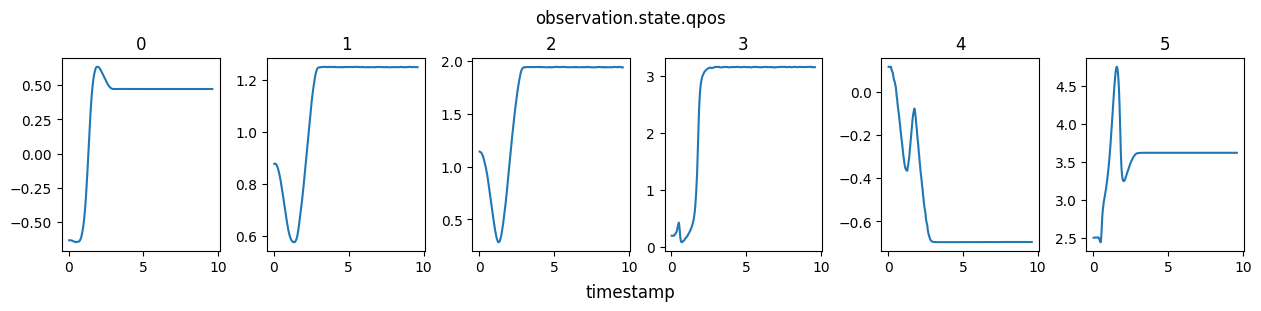

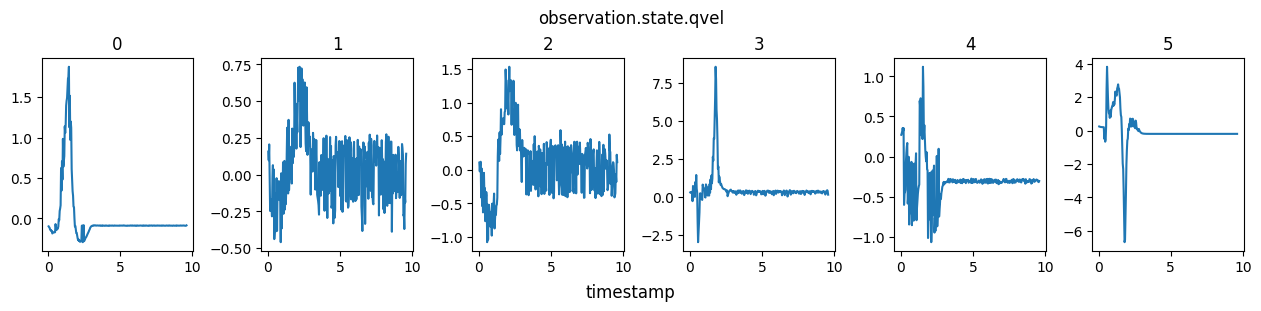

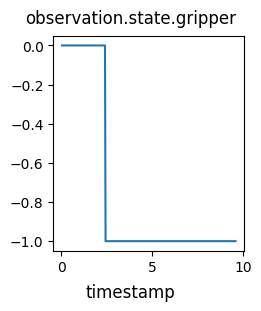

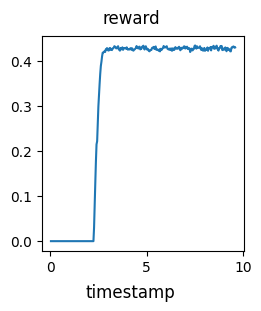

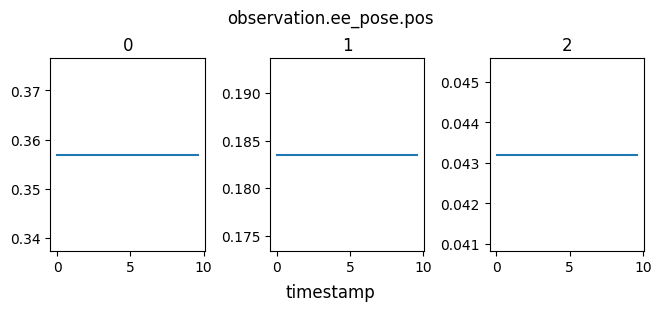

In [105]:

gym_lite6.utils.plot_dict_of_arrays(dataset.episode_buffer, "timestamp", keys=["action.qpos", "observation.state.qpos", "observation.state.qvel", "observation.state.gripper", "reward", "observation.ee_pose.pos"], sharey=False)


# 2. Test dataset
Open loop replay

In [ ]:
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset

# DIffusion
# delta_timestamps = {
#     # Load the previous image and state at -0.1 seconds before current frame,
#     # then load current image and state corresponding to 0.0 second.
#     "observation.image": [-0.1, 0.0],
#     "observation.state": [-0.1, 0.0],
#     # Load the previous action (-0.1), the next action to be executed (0.0),
#     # and 14 future actions with a 0.1 seconds spacing. All these actions will be
#     # used to supervise the policy.
#     "action": [-0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4],
# }

# ACT
delta_timestamps = {
    # Load the previous image and state at -0.1 seconds before current frame,
    # then load current image and state corresponding to 0.0 second.
    "observation.image": [-0.1, 0.0],
    "observation.state": [-0.1, 0.0],
    # Load the previous action (-0.1), the next action to be executed (0.0),
    # and 14 future actions with a 0.1 seconds spacing. All these actions will be
    # used to supervise the policy.
    "action": [-0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4],
}

dataset_name = "lite6_record_scripted_250412"
# may need to change the metadata fps to 31.25 and increase the tolerance
# dataset = LeRobotDataset("eufrizz/" + dataset_name,root="datasets/" + dataset_name, local_files_only=True)
dataset = LeRobotDataset("eufrizz/" + dataset_name,root="datasets/" + dataset_name)


In [81]:
dataset = LeRobotDataset("eufrizz/" + dataset_name,root="datasets/" + dataset_name, revision="v2.0")


The dataset you requested (eufrizz/grasp_and_lift_random_50_2024-09-18_16-52-04) is in 2.0 format.
While current version of LeRobot is backward-compatible with it, the version of your dataset still uses global
stats instead of per-episode stats. Update your dataset stats to the new format using this command:
```
python lerobot/common/datasets/v21/convert_dataset_v20_to_v21.py --repo-id=eufrizz/grasp_and_lift_random_50_2024-09-18_16-52-04
```

If you encounter a problem, contact LeRobot maintainers on [Discord](https://discord.com/invite/s3KuuzsPFb)
or open an [issue on GitHub](https://github.com/huggingface/lerobot/issues/new/choose).



Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
from lerobot.common.datasets.lerobot_dataset import CODEBASE_VERSION, LeRobotDataset
from lerobot.common.datasets.utils import EPISODES_STATS_PATH, STATS_PATH, load_stats, write_info
from lerobot.common.datasets.v21.convert_stats import check_aggregate_stats, convert_stats
if (dataset.root / EPISODES_STATS_PATH).is_file():
        (dataset.root / EPISODES_STATS_PATH).unlink()

convert_stats(dataset, num_workers=2)
ref_stats = load_stats(dataset.root)
check_aggregate_stats(dataset, ref_stats)

dataset.meta.info["codebase_version"] = CODEBASE_VERSION
write_info(dataset.meta.info, dataset.root)

In [78]:
ep_idx = 0
from_idx = dataset.episode_data_index["from"][ep_idx].item()
to_idx = dataset.episode_data_index["to"][ep_idx].item()

observation, info = env.reset(qpos=dataset[from_idx]["action"][:6])

step = 0
done = False
images = [observation["pixels"]["side"]]
# ep_dict = {"action.qpos": [], "action.gripper": [], "observation.state.qpos": [], "observation.state.qvel": [], "observation.state.gripper": [], "observation.pixels.side": [], "observation.pixels.gripper": [], "reward": [], "timestamp": [], "frame_index": [],}

for idx in range(from_idx, to_idx):
    # start_loop_t = time.perf_counter()
    frame = dataset[idx]
    # print(idx - from_idx)
    action = {"gripper": int(frame["action"][-1]), "qpos": frame["action"][:6]}
    observation, reward, terminated, truncated, info = env.step(action)
    images.append(observation["pixels"]["side"])

media.show_videos([images])


In [142]:
int(frame["action"][-1])

0

TypeError: len() of a 0-d tensor

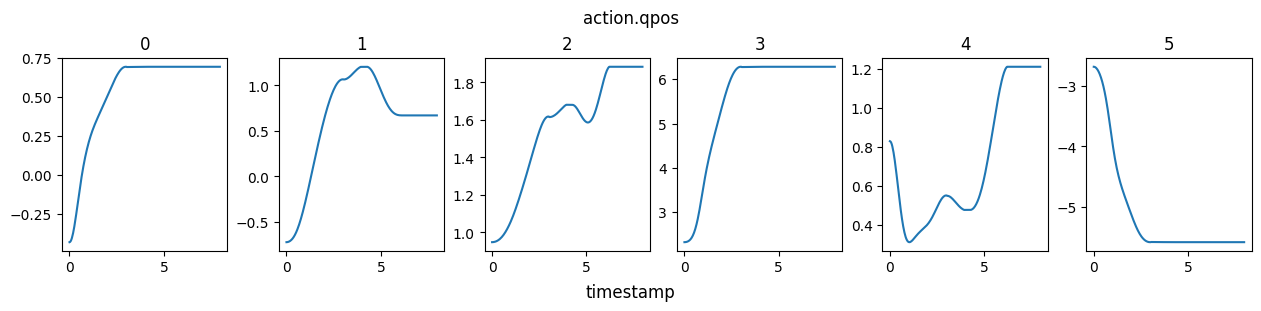

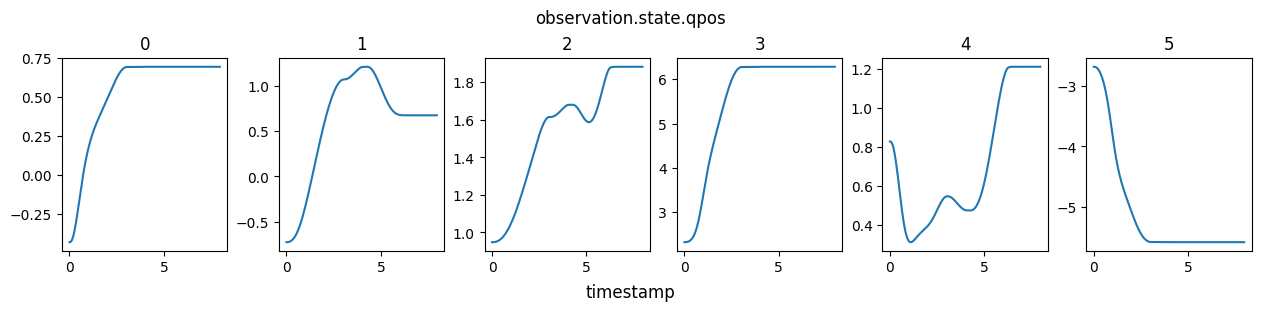

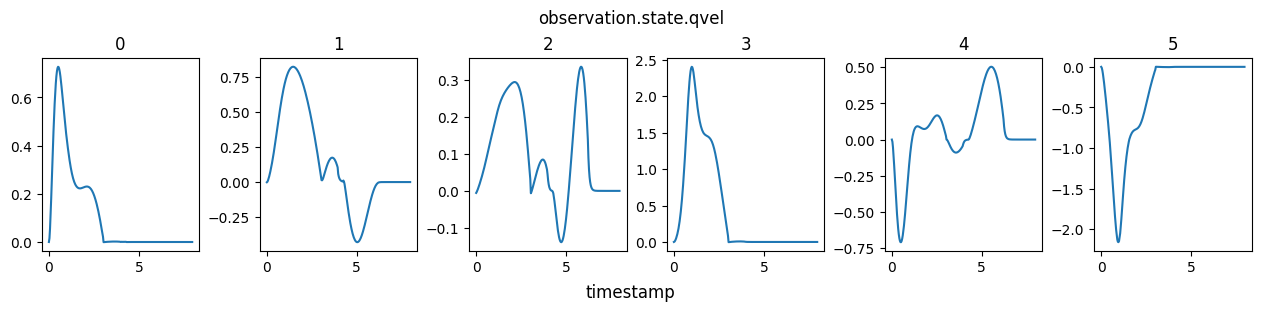

In [84]:
gym_lite6.utils.plot_dict_of_arrays(dataset.hf_dataset[from_idx:to_idx], "timestamp", keys=["action.qpos", "observation.state.qpos", "observation.state.qvel", "observation.state.gripper", "reward", "observation.ee_pose.pos"], sharey=False)


# 3. Train policy

In [26]:
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset
from operator import add
import torch

delta_timestamps = {
    # Load the previous image and state at -0.1 seconds before current frame,
    # then load current image and state corresponding to 0.0 second.
    "observation.state": [-0.096, 0.0],
    # "observation.state.qpos": [-0.096, 0.0],
    "observation.pixels.gripper": [-0.096, 0.0],
    "observation.pixels.side": [-0.096, 0.0],
    # Load the previous action (-0.096), the next action to be executed (0.0),
    # and 14 future actions with a 0.096 seconds spacing. All these actions will be
    # used to supervise the policy.
    "action": [-0.096, 0.0, 0.096, 0.192, 0.288, 0.384, 0.512, 0.608, 0.704, 0.8, 0.896, 1.024, 1.12, 1.216, 1.312, 1.408],
    # "action.gripper": [-0.096, 0.0, 0.096, 0.192, 0.288, 0.384, 0.512, 0.608, 0.704, 0.8, 0.896, 1.024, 1.12, 1.216, 1.312, 1.408],
}

dataset_name = "grasp_and_lift_random_50_2024-09-18_16-52-04"
# may need to change the metadata fps to 31.25 and increase the tolerance
dataset = LeRobotDataset("eufrizz/" + dataset_name,root="datasets/" + dataset_name, local_files_only=True, delta_timestamps=delta_timestamps)

# from lerobot.common.datasets.utils import hf_transform_to_torch
# def transform(row):
#     # print(type(row["action.qpos"]))
#     if "observation.qpos" in row and "observation.gripper" in row:
#         row["observation"] = row["observation.qpos"] + row["observation.gripper"]
#     return hf_transform_to_torch(row)
# dataset.hf_dataset.set_transform(transform)

# We need to combine the qpos/qvel with gripper, to form one observation.state - the way diffusion is set up 
# input_features["observation.state"] = PolicyFeature(FeatureType.STATE, tuple(map(add, features['observation.state.qpos'].shape, features['observation.state.gripper'].shape)))
dataset.features["observation.state"] = {"dtype": dataset.features["observation.state.qpos"]["dtype"],
                                         "shape": tuple(map(add, dataset.features['observation.state.qpos']["shape"], dataset.features['observation.state.gripper']["shape"]))}

dataset.meta.stats['observation.state'] = {key: torch.hstack([dataset.meta.stats['observation.state.qpos'][key], dataset.meta.stats['observation.state.gripper'][key]]) for key in dataset.meta.stats['observation.state.qpos']}
def obs_col(x):
    x["observation.state"] = [torch.cat([x["observation.state.qpos"][i], x["observation.state.gripper"][i].unsqueeze(0)]) for i in range(len(x["observation.state.qpos"]))]
    return x
dataset.hf_dataset = dataset.hf_dataset.map(obs_col, batched=True)


Returning existing local_dir `datasets/grasp_and_lift_random_50_2024-09-18_16-52-04` as remote repo cannot be accessed in `snapshot_download` (None).
Returning existing local_dir `datasets/grasp_and_lift_random_50_2024-09-18_16-52-04` as remote repo cannot be accessed in `snapshot_download` (None).


Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
from lerobot.common.datasets.utils import dataset_to_policy_features
from lerobot.common.policies.diffusion.configuration_diffusion import DiffusionConfig
from lerobot.common.policies.diffusion.modeling_diffusion import DiffusionPolicy
from lerobot.configs.types import DictLike, FeatureType, PolicyFeature

features = dataset_to_policy_features(dataset.features)
output_features = {key: ft for key, ft in features.items() if ft.type is FeatureType.ACTION}
input_features = {key: ft for key, ft in features.items() if ft.type is FeatureType.VISUAL or key == "observation.state"}

cfg = DiffusionConfig(
    input_features=input_features,
    output_features=output_features,
    crop_shape=None
)
policy = DiffusionPolicy(cfg, dataset_stats=dataset.meta.stats)
optimizer = torch.optim.Adam(policy.parameters(), lr=1e-4)

device = torch.device("cuda")
policy.to(device);


In [28]:
dataloader = torch.utils.data.DataLoader(
    dataset,
    num_workers=1,
    batch_size=1,
    shuffle=True,
    pin_memory=device != torch.device("cpu"),
    drop_last=True,
)

In [29]:
# import tracemalloc

# tracemalloc.start()
training_steps = 5000

step = 0
done = False
while not done:
    for batch in dataloader:
        # batch["observation.state"] = torch.cat([batch["observation.state.qpos"], batch["observation.state.gripper"].unsqueeze(2)], 2)
        batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}
        output_dict = policy.forward(batch)
        loss = output_dict["loss"]
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()        

        if step % 250 == 0:
            print(f"step: {step} loss: {loss.item():.3f}")
        step += 1
        if step >= training_steps:
            done = True
            break
        # dataset.hf_dataset.clear_cache()
        
# snapshot = tracemalloc.take_snapshot()
# top_stats = snapshot.statistics('lineno')  # Get statistics by line number
# for stat in top_stats[:10]:  # Show top 10 memory allocations
#     print(stat)
# tracemalloc.stop()  # Stop tracing
policy.save_pretrained(f"ckpts/grasp_and_lift_diffusion_step_{step}")


step: 0 loss: 1.324
step: 250 loss: 0.530
step: 500 loss: 0.131
step: 750 loss: 0.309
step: 1000 loss: 0.172
step: 1250 loss: 0.063
step: 1500 loss: 0.062
step: 1750 loss: 0.170
step: 2000 loss: 0.032
step: 2250 loss: 0.131
step: 2500 loss: 0.122
step: 2750 loss: 0.102
step: 3000 loss: 0.059
step: 3250 loss: 0.072
step: 3500 loss: 0.069
step: 3750 loss: 0.073
step: 4000 loss: 0.013
step: 4250 loss: 0.097
step: 4500 loss: 0.030
step: 4750 loss: 0.048


# 4. Evaluate policy

In [75]:
from lerobot.common.policies.diffusion.modeling_diffusion import DiffusionPolicy
import torch
device = "cuda"
policy = DiffusionPolicy.from_pretrained("ckpts/grasp_and_lift_diffusion_step_5000").to(device)
policy.eval()

Loading weights from local directory


DiffusionPolicy(
  (normalize_inputs): Normalize(
    (buffer_observation_pixels_side): ParameterDict(
        (mean): Parameter containing: [torch.cuda.FloatTensor of size 3x1x1 (cuda:0)]
        (std): Parameter containing: [torch.cuda.FloatTensor of size 3x1x1 (cuda:0)]
    )
    (buffer_observation_pixels_gripper): ParameterDict(
        (mean): Parameter containing: [torch.cuda.FloatTensor of size 3x1x1 (cuda:0)]
        (std): Parameter containing: [torch.cuda.FloatTensor of size 3x1x1 (cuda:0)]
    )
    (buffer_observation_state): ParameterDict(
        (max): Parameter containing: [torch.cuda.FloatTensor of size 7 (cuda:0)]
        (min): Parameter containing: [torch.cuda.FloatTensor of size 7 (cuda:0)]
    )
  )
  (normalize_targets): Normalize(
    (buffer_action): ParameterDict(
        (max): Parameter containing: [torch.cuda.FloatTensor of size 7 (cuda:0)]
        (min): Parameter containing: [torch.cuda.FloatTensor of size 7 (cuda:0)]
    )
  )
  (unnormalize_outputs): U

In [76]:
observation, info = env.reset()

step = 0
done = False
images = [observation["pixels"]["side"]]
ep_dict = {"action.qpos": [], "action.gripper": [], "observation.state.qpos": [], "observation.state.qvel": [], "observation.state.gripper": [], "observation.pixels.side": [], "observation.pixels.gripper": [], "reward": [], "timestamp": [], "frame_index": [],}

while not done:
    # start_loop_t = time.perf_counter()
    # print(idx - from_idx)
    # action = {"gripper": int(frame["action"][-1]), "qpos": frame["action"][:6]}
    # tuple(map(add, dataset.features['observation.state.qpos']["shape"], dataset.features['observation.state.gripper']["shape"]))
    observation["observation.state"] = torch.from_numpy(np.float32(np.hstack((observation["state"]["qpos"], observation["state"]["gripper"])))).unsqueeze(0).to(device)
    observation["observation.pixels.side"] = torch.from_numpy(observation['pixels']['side']).permute((2,0,1)).unsqueeze(0).to(device)
    observation["observation.pixels.gripper"] = torch.from_numpy(observation['pixels']['gripper']).permute((2,0,1)).unsqueeze(0).to(device)
    
    with torch.inference_mode():
        action = policy.select_action(observation).detach().cpu()[0]
    action = {"qpos": action[:env.unwrapped.dof], "gripper": round(action[-1].item())}
    
    observation, reward, terminated, truncated, info = env.step(action)
    images.append(observation["pixels"]["side"])

    ep_dict["action.qpos"].append(action["qpos"])
    ep_dict["action.gripper"].append(action["gripper"])
    ep_dict["observation.state.qpos"].append(observation["state"]["qpos"])
    ep_dict["observation.state.qvel"].append(observation["state"]["qvel"])
    ep_dict["observation.state.gripper"].append(observation["state"]["gripper"])
    ep_dict["observation.pixels.side"].append(observation["pixels"]["side"])
    ep_dict["observation.pixels.gripper"].append(observation["pixels"]["gripper"])
    ep_dict["reward"].append(reward)
    ep_dict["timestamp"].append(env.unwrapped.data.time)
    ep_dict["frame_index"].append(step)

    done = terminated | truncated | done
    step += 1
    # break

media.show_videos([images])
# action
# media.write_video("diffusion_step_1000.mp4", images)



/media/ssd/eugene/robotic_manipulation/lerobot_venv/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


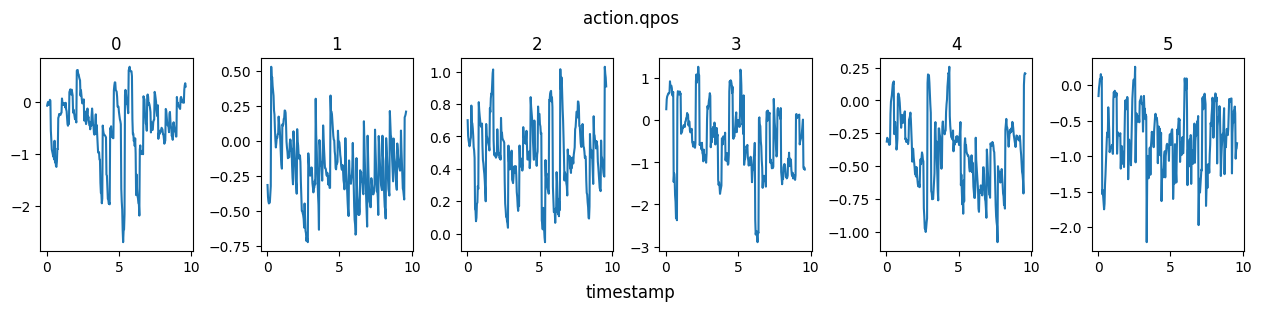

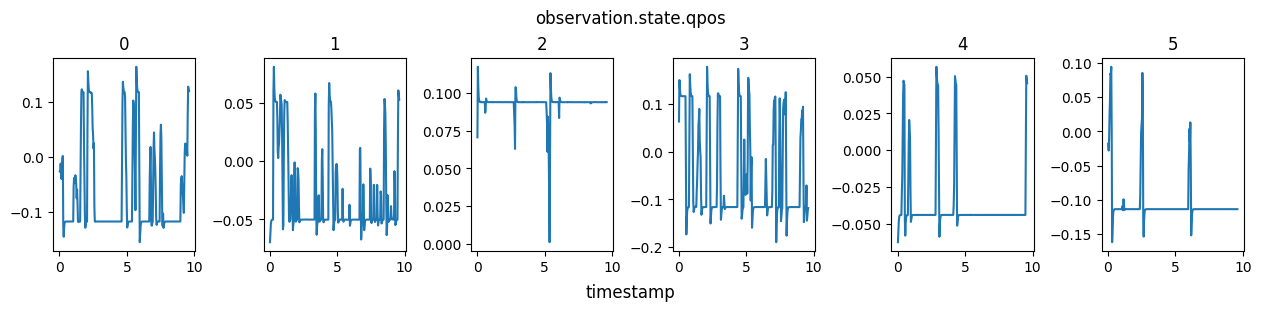

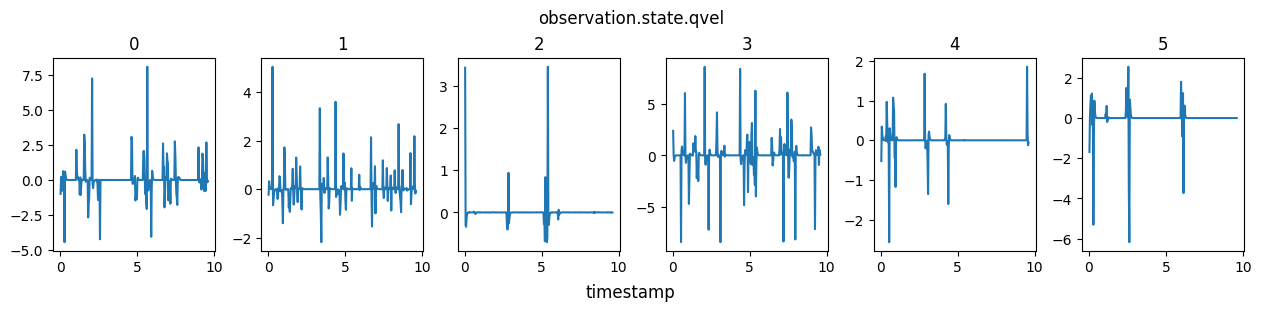

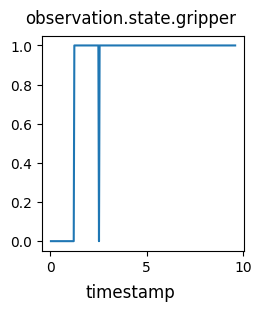

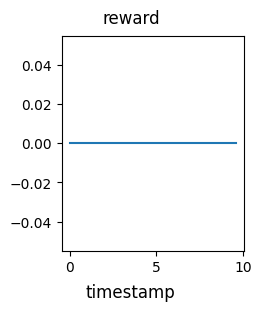

In [77]:
gym_lite6.utils.plot_dict_of_arrays(ep_dict, "timestamp", keys=["action.qpos", "observation.state.qpos", "observation.state.qvel", "observation.state.gripper", "reward"], sharey=False)


TODO:
- Logging during training
- Train for longer
- Compare to existing Lerobot robot arm envs to see what might be failing
- Is it a data issue?
- End effector velocity

# ACT


In [2]:
import torch
import lerobot
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset, LeRobotDatasetMetadata
from pprint import pprint
from lerobot.common.policies.act.modeling_act import ACTConfig, ACTPolicy
from lerobot.common.envs.configs import AlohaEnv
from lerobot.common.datasets.utils import dataset_to_policy_features
from lerobot.configs.types import FeatureType
import mediapy as media
from lerobot.common.datasets.factory import make_dataset
import lerobot.common.envs.factory
import numpy as np

In [ ]:

dataset_metadata = LeRobotDatasetMetadata("lerobot/aloha_sim_transfer_cube_scripted")
features = dataset_to_policy_features(dataset_metadata.features)
output_features = {key: ft for key, ft in features.items() if ft.type is FeatureType.ACTION}
input_features = {key: ft for key, ft in features.items() if key not in output_features}

# Create TDMPC config
# cfg = TDMPCConfig(
#     input_features=input_features,
#     output_features=output_features,
#     # use_mpc=True,
# )
cfg = ACTConfig(input_features=input_features, output_features=output_features)
# env = AlohaEnv(task="AlohaTransferCube-v0")

delta_timestamps = {
    "action": [i / dataset_metadata.fps for i in cfg.action_delta_indices],
}
dataset = LeRobotDataset("lerobot/aloha_sim_transfer_cube_scripted", delta_timestamps=delta_timestamps)
# dataset = make_dataset(da)
env_cfg = lerobot.common.envs.factory.make_env_config("aloha", task="AlohaTransferCube-v0")
env = lerobot.common.envs.factory.make_env(env_cfg)

device = "cuda"
policy = ACTPolicy(cfg, dataset_metadata.stats)
policy.to(device)
policy.train()
step = 0


In [17]:
pprint(cfg)

ACTConfig(n_obs_steps=1,
          normalization_mapping={'ACTION': <NormalizationMode.MEAN_STD: 'MEAN_STD'>,
                                 'STATE': <NormalizationMode.MEAN_STD: 'MEAN_STD'>,
                                 'VISUAL': <NormalizationMode.MEAN_STD: 'MEAN_STD'>},
          input_features={'observation.images.top': PolicyFeature(type=<FeatureType.VISUAL: 'VISUAL'>,
                                                                  shape=(3,
                                                                         480,
                                                                         640)),
                          'observation.state': PolicyFeature(type=<FeatureType.STATE: 'STATE'>,
                                                             shape=(14,))},
          output_features={'action': PolicyFeature(type=<FeatureType.ACTION: 'ACTION'>,
                                                   shape=(14,))},
          device='cuda',
          use_amp=False,
       

In [3]:
dataset_name = "lite6_record_scripted_250413_50fps"
dataset_metadata = LeRobotDatasetMetadata("eufrizz/" + dataset_name,root="datasets/" + dataset_name)
dataset_metadata

LeRobotDatasetMetadata({
    Repository ID: 'eufrizz/lite6_record_scripted_250413_50fps',
    Total episodes: '50',
    Total frames: '11216',
    Features: '['action', 'observation.state.qpos', 'observation.state.qvel', 'observation.state.gripper', 'observation.ee_pose.pos', 'observation.ee_pose.quat', 'observation.ee_pose.vel', 'observation.ee_pose.ang_vel', 'observation.images.gripper', 'observation.images.side', 'episode_index', 'frame_index', 'timestamp', 'reward', 'index', 'task_index']',
})',

In [4]:
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset
from operator import add
import torch

dataset_metadata = LeRobotDatasetMetadata("eufrizz/" + dataset_name,root="datasets/" + dataset_name)
# features = dataset_to_policy_features(dataset_metadata.features)
# output_features = {key: ft for key, ft in features.items() if ft.type is FeatureType.ACTION}
# # input_features = {key: ft for key, ft in features.items() if key not in output_features}
# input_features = {key: ft for key, ft in features.items() if key in ["observation.state"]}


delta_timestamps = {
    "action": [i / dataset_metadata.fps for i in ACTConfig().action_delta_indices],
    # "action": [0.0, 0.0],
}
print(delta_timestamps)

# may need to change the metadata fps to 31.25 and increase the tolerance
dataset = LeRobotDataset("eufrizz/" + dataset_name,root="datasets/" + dataset_name, delta_timestamps=delta_timestamps)

dataset.features["observation.state"] = {"dtype": dataset.features["observation.state.qpos"]["dtype"],
                                         "shape": tuple(map(add, dataset.features['observation.state.qpos']["shape"], dataset.features['observation.state.gripper']["shape"]))}

dataset.meta.stats['observation.state'] = {key: np.hstack([dataset.meta.stats['observation.state.qpos'][key], dataset.meta.stats['observation.state.gripper'][key]]) for key in dataset.meta.stats['observation.state.qpos']}
def obs_col(x):
    x["observation.state"] = [torch.cat([x["observation.state.qpos"][i], x["observation.state.gripper"][i].unsqueeze(0)]) for i in range(len(x["observation.state.qpos"]))]
    return x
dataset.hf_dataset = dataset.hf_dataset.map(obs_col, batched=True)

features = dataset_to_policy_features(dataset_metadata.features)
output_features = {key: ft for key, ft in features.items() if ft.type is FeatureType.ACTION}
# input_features = {key: ft for key, ft in features.items() if key not in output_features}
input_features = {key: ft for key, ft in features.items() if key in ["observation.state", "observation.images.side"]}


cfg = ACTConfig(input_features=input_features, output_features=output_features)


# env_cfg = lerobot.common.envs.factory.make_env_config("aloha", task="AlohaTransferCube-v0")
# env = lerobot.common.envs.factory.make_env(env_cfg)
task = gym_lite6.pickup_task.GraspAndLiftTask('gripper_left_finger', 'gripper_right_finger', 'box', 'floor')
env = gym.make(
    "UfactoryCubePickup-v0",
    task=task,
    obs_type="pixels_state",
    max_episode_steps=300,
    visualization_width=320,
    visualization_height=240
)

device = "cuda"
policy = ACTPolicy(cfg, dataset_metadata.stats)
policy.to(device)
policy.train()
step = 0
# We need to combine the qpos/qvel with gripper, to form one observation.state - the way diffusion is set up 
# input_features["observation.state"] = PolicyFeature(FeatureType.STATE, tuple(map(add, features['observation.state.qpos'].shape, features['observation.state.gripper'].shape)))



{'action': [0.0, 0.032, 0.064, 0.096, 0.128, 0.16, 0.192, 0.224, 0.256, 0.288, 0.32, 0.352, 0.384, 0.416, 0.448, 0.48, 0.512, 0.544, 0.576, 0.608, 0.64, 0.672, 0.704, 0.736, 0.768, 0.8, 0.832, 0.864, 0.896, 0.928, 0.96, 0.992, 1.024, 1.056, 1.088, 1.12, 1.152, 1.184, 1.216, 1.248, 1.28, 1.312, 1.344, 1.376, 1.408, 1.44, 1.472, 1.504, 1.536, 1.568, 1.6, 1.632, 1.664, 1.696, 1.728, 1.76, 1.792, 1.824, 1.856, 1.888, 1.92, 1.952, 1.984, 2.016, 2.048, 2.08, 2.112, 2.144, 2.176, 2.208, 2.24, 2.272, 2.304, 2.336, 2.368, 2.4, 2.432, 2.464, 2.496, 2.528, 2.56, 2.592, 2.624, 2.656, 2.688, 2.72, 2.752, 2.784, 2.816, 2.848, 2.88, 2.912, 2.944, 2.976, 3.008, 3.04, 3.072, 3.104, 3.136, 3.168]}


Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

In [104]:
# cfg.output_features, cfg.input_features
reload(lerobot)

<module 'lerobot' from '/media/ssd/eugene/robotic_manipulation/lerobot/lerobot/__init__.py'>

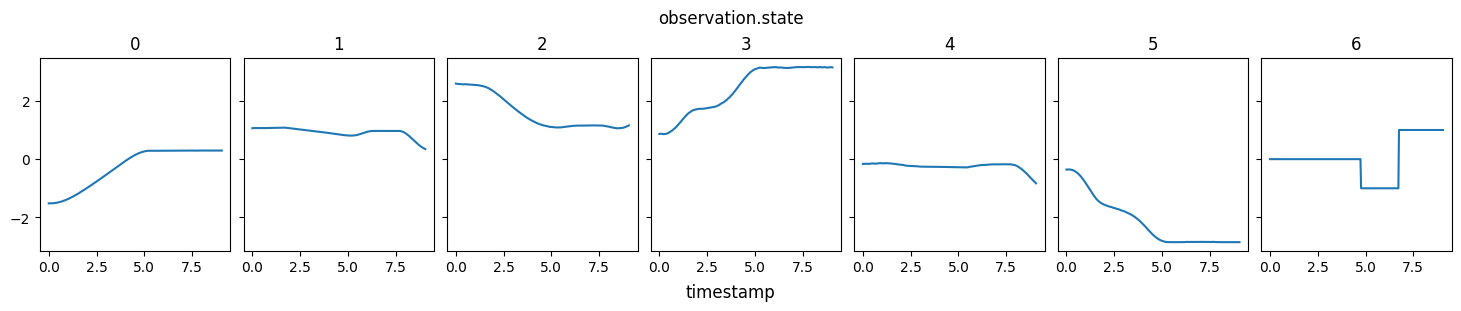

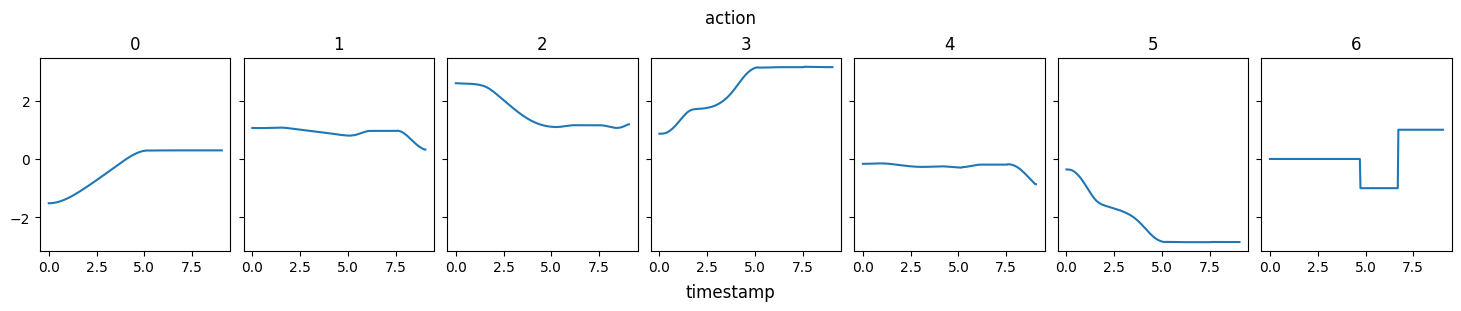

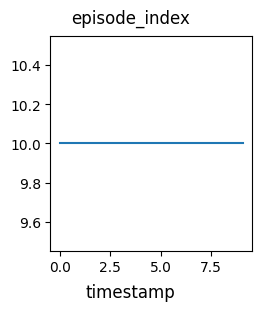

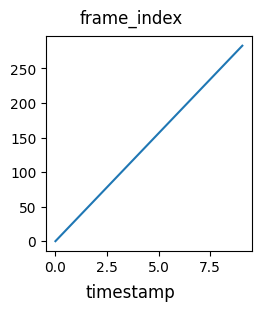

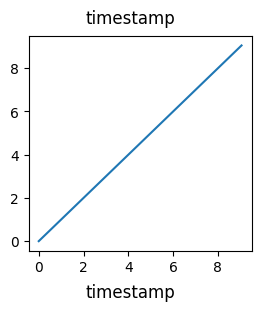

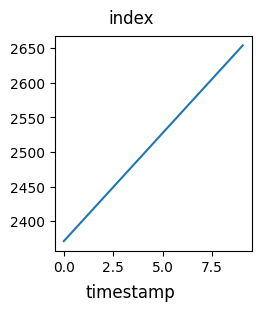

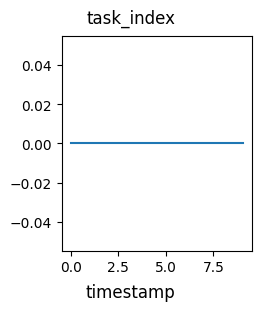

In [13]:
ep_idx = 10
from_idx = dataset.episode_data_index["from"][ep_idx].item()
to_idx = dataset.episode_data_index["to"][ep_idx].item()

replay_frames = []
orig_frames = []
gripper_frames = []
action = {"gripper": int(dataset[from_idx]["action"][0][-1]), "qpos": dataset[from_idx]["action"][0][:6]}
observation, info = env.reset(qpos=action["qpos"])

for idx in range(from_idx, to_idx):
    frame = dataset[idx]
    action = {"gripper": int(frame["action"][0][-1]), "qpos": frame["action"][0][:6]}
    # action = {"gripper": data["action.gripper"], "qpos": data["action.qpos"]}
    # print(action)
    observation, reward, terminated, truncated, info = env.step(action)
    # print(observation)
    replay_frames.append(observation["pixels"]["side"])
    orig_frames.append(np.array(frame["observation.images.side"].permute(1,2,0)))
    gripper_frames.append(np.array(frame["observation.images.gripper"].permute(1,2,0)))
    # orig_frames.append(data["observation.pixels.side"])

media.show_videos([replay_frames, orig_frames, gripper_frames])

gym_lite6.utils.plot_dict_of_arrays(dataset.hf_dataset[from_idx:to_idx], "timestamp", ["observation.state", 'action', 'episode_index', 'frame_index', 'timestamp', 'index', 'task_index'])

# step = 0
# done = False
# images = [observation["pixels"]["side"]]
# # ep_dict = {"action.qpos": [], "action.gripper": [], "observation.state.qpos": [], "observation.state.qvel": [], "observation.state.gripper": [], "observation.pixels.side": [], "observation.pixels.gripper": [], "reward": [], "timestamp": [], "frame_index": [],}

# for idx in range(from_idx, to_idx):
#     # start_loop_t = time.perf_counter()
#     frame = dataset[idx]
#     # print(idx - from_idx)
#     action = {"gripper": int(frame["action"][-1]), "qpos": frame["action"][:6]}
#     observation, reward, terminated, truncated, info = env.step(action)
#     images.append(observation["pixels"]["side"])

# media.show_videos([images])


In [6]:
optim_params = policy.get_optim_params() # if cfg.use_policy_training_preset else policy.parameters()
# policy.get_optimizer_preset()
# scheduler = cfg.get_scheduler_preset().build(optim_params)
optimizer = cfg.get_optimizer_preset().build(optim_params)

dataloader = torch.utils.data.DataLoader(
    dataset,
    num_workers=1,
    batch_size=64,
    shuffle=True,
    pin_memory=device != torch.device("cpu"),
    drop_last=True,
)

In [7]:
dataset_name

'lite6_record_scripted_250413_50fps'

```
{'batch_size': 8,
 'dataset': {'episodes': None,
             'image_transforms': {'enable': False,
                                  'max_num_transforms': 3,
                                  'random_order': False,
                                  'tfs': {'brightness': {'kwargs': {'brightness': [0.8,
                                                                                   1.2]},
                                                         'type': 'ColorJitter',
                                                         'weight': 1.0},
                                          'contrast': {'kwargs': {'contrast': [0.8,
                                                                               1.2]},
                                                       'type': 'ColorJitter',
                                                       'weight': 1.0},
                                          'hue': {'kwargs': {'hue': [-0.05,
                                                                     0.05]},
                                                  'type': 'ColorJitter',
                                                  'weight': 1.0},
                                          'saturation': {'kwargs': {'saturation': [0.5,
                                                                                   1.5]},
                                                         'type': 'ColorJitter',
                                                         'weight': 1.0},
                                          'sharpness': {'kwargs': {'sharpness': [0.5,
                                                                                 1.5]},
                                                        'type': 'SharpnessJitter',
                                                        'weight': 1.0}}},
             'repo_id': 'lerobot/aloha_sim_transfer_cube_human',
             'revision': None,
             'root': None,
             'use_imagenet_stats': True,
             'video_backend': 'pyav'},
 'env': {'episode_length': 400,
         'features': {'action': {'shape': [14],
                                 'type': <FeatureType.ACTION: 'ACTION'>},
                      'agent_pos': {'shape': [14],
                                    'type': <FeatureType.STATE: 'STATE'>},
                      'pixels/top': {'shape': [480, 640, 3],
                                     'type': <FeatureType.VISUAL: 'VISUAL'>}},
         'features_map': {'action': 'action',
                          'agent_pos': 'observation.state',
                          'pixels/top': 'observation.images.top',
                          'top': 'observation.image.top'},
         'fps': 50,
         'obs_type': 'pixels_agent_pos',
         'render_mode': 'rgb_array',
         'task': 'AlohaTransferCube-v0',
         'type': 'aloha'},
 'eval': {'batch_size': 50, 'n_episodes': 50, 'use_async_envs': False},
 'eval_freq': 20000,
 'job_name': 'aloha_act',
 'log_freq': 200,
 'num_workers': 4,
 'optimizer': {'betas': [0.9, 0.999],
               'eps': 1e-08,
               'grad_clip_norm': 10.0,
               'lr': 1e-05,
               'type': 'adamw',
               'weight_decay': 0.0001},
 'output_dir': 'outputs/train/act_aloha_transfer',
 'policy': {'chunk_size': 100,
            'device': 'cuda',
            'dim_feedforward': 3200,
            'dim_model': 512,
            'dropout': 0.1,
            'feedforward_activation': 'relu',
            'input_features': {},
            'kl_weight': 10.0,
            'latent_dim': 32,
            'n_action_steps': 100,
            'n_decoder_layers': 1,
            'n_encoder_layers': 4,
            'n_heads': 8,
            'n_obs_steps': 1,
            'n_vae_encoder_layers': 4,
            'normalization_mapping': {'ACTION': <NormalizationMode.MEAN_STD: 'MEAN_STD'>,
                                      'STATE': <NormalizationMode.MEAN_STD: 'MEAN_STD'>,
                                      'VISUAL': <NormalizationMode.MEAN_STD: 'MEAN_STD'>},
            'optimizer_lr': 1e-05,
            'optimizer_lr_backbone': 1e-05,
            'optimizer_weight_decay': 0.0001,
            'output_features': {},
            'pre_norm': False,
            'pretrained_backbone_weights': 'ResNet18_Weights.IMAGENET1K_V1',
            'replace_final_stride_with_dilation': False,
            'temporal_ensemble_coeff': None,
            'type': 'act',
            'use_amp': False,
            'use_vae': True,
            'vision_backbone': 'resnet18'},
 'resume': False,
 'save_checkpoint': True,
 'save_freq': 20000,
 'scheduler': None,
 'seed': 1000,
 'steps': 100000,
 'use_policy_training_preset': True,
 'wandb': {'disable_artifact': False,
           'enable': False,
           'entity': None,
           'notes': None,
           'project': 'lerobot'}}
```

In [ ]:

policy.train()

num_steps = 10000
dl_iter = iter(dataloader)
for _ in range(step, num_steps):
    try:
        batch = next(dl_iter)
    except StopIteration:
        dl_iter = iter(dataloader)
        batch = next(dl_iter)
    
    for key in batch:
        if isinstance(batch[key], torch.Tensor):
            batch[key] = batch[key].to(device, non_blocking=True)
    loss, output_dict = policy.forward(batch)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if step % 250 == 0:
        print(f"step: {step} loss: {loss.item():.3f}")
    if step % 1000 == 0:
        policy.save_pretrained(f"ckpts/act_lite6_{dataset_name}_step_{step}")
    step += 1

policy.save_pretrained(f"ckpts/act_lite6_{dataset_name}_step_{step}")


step: 0 loss: 80.025
step: 250 loss: 2.858
step: 500 loss: 2.221
step: 750 loss: 1.861
step: 1000 loss: 1.563
step: 1250 loss: 1.336
step: 1500 loss: 1.098
step: 1750 loss: 0.958
step: 2000 loss: 0.816
step: 2250 loss: 0.718
step: 2500 loss: 0.583
step: 2750 loss: 0.517
step: 3000 loss: 0.449
step: 3250 loss: 0.400
step: 3500 loss: 0.335
step: 3750 loss: 0.307
step: 4000 loss: 0.279
step: 4250 loss: 0.240
step: 4500 loss: 0.238
step: 4750 loss: 0.203
step: 5000 loss: 0.188
step: 5250 loss: 0.176
step: 5500 loss: 0.172
step: 5750 loss: 0.159
step: 6000 loss: 0.150
step: 6250 loss: 0.138
step: 6500 loss: 0.134
step: 6750 loss: 0.130
step: 7000 loss: 0.116
step: 7250 loss: 0.113
step: 7500 loss: 0.110
step: 7750 loss: 0.106
step: 8000 loss: 0.102
step: 8250 loss: 0.101
step: 8500 loss: 0.097
step: 8750 loss: 0.086
step: 9000 loss: 0.087
step: 9250 loss: 0.079
step: 9500 loss: 0.084
step: 9750 loss: 0.076


In [28]:
task = gym_lite6.pickup_task.GraspAndLiftTask('gripper_left_finger', 'gripper_right_finger', 'box', 'floor')
env = gym.make(
    "UfactoryCubePickup-v0",
    task=task,
    obs_type="pixels_state",
    max_episode_steps=500,
    visualization_width=320,
    visualization_height=240
)

Loading weights from local directory


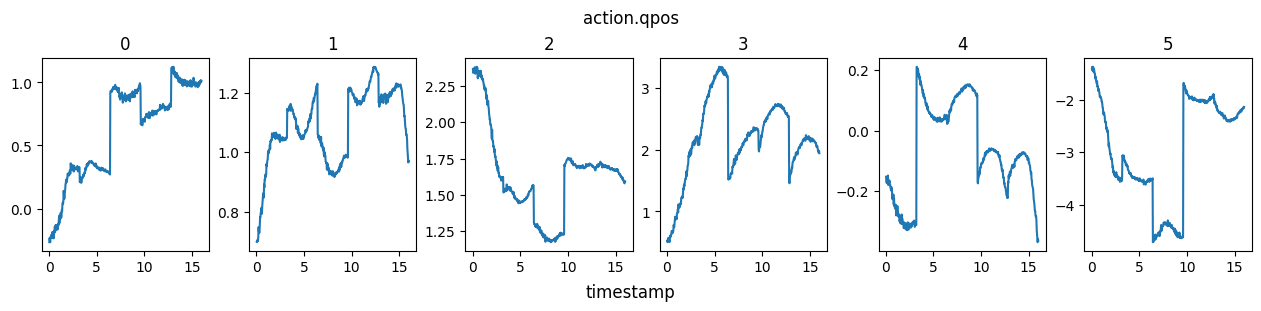

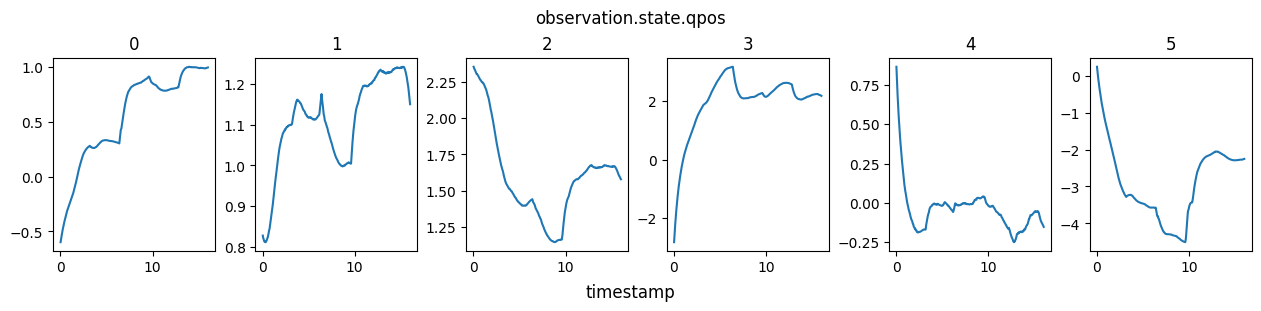

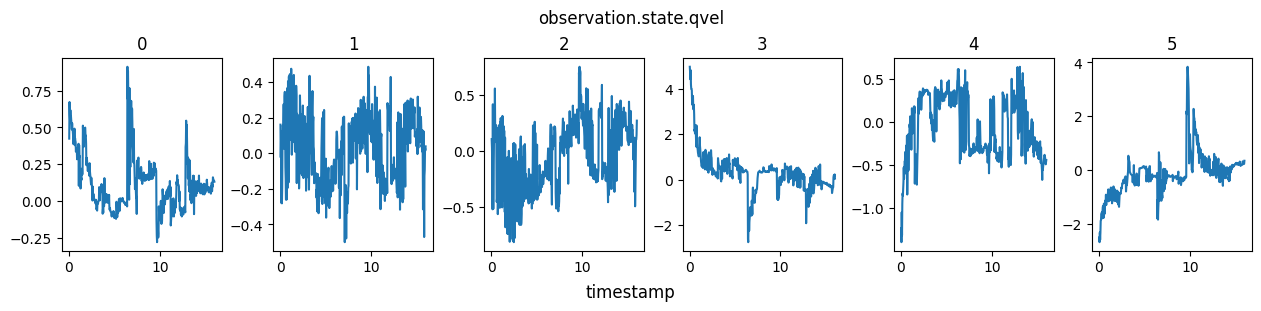

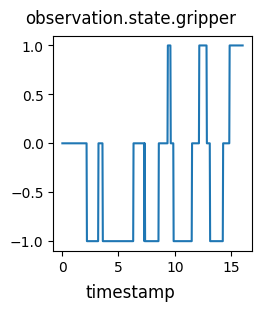

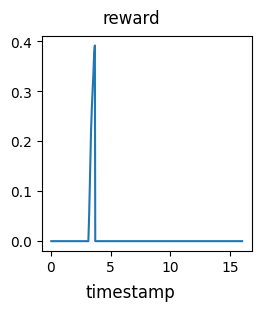

In [ ]:
device = "cuda"
step = 3000
policy = ACTPolicy.from_pretrained(f"ckpts/act_lite6_step_lite6_record_scripted_250413_50fps_{step}")
policy.to(device)
policy.eval()

# def eval():
numpy_observation, info = env.reset()
rewards = []
frames = [numpy_observation["pixels"]["side"].squeeze()]
done = False
observation = {}

ep_dict = {"action.qpos": [], "action.gripper": [], "observation.state.qpos": [], "observation.state.qvel": [], "observation.state.gripper": [], "observation.images.side": [], "observation.images.gripper": [], "reward": [], "timestamp": [], "frame_index": [],}
while not done:
    # observation["observation.state"] = torch.from_numpy(numpy_observation["agent_pos"]).to(torch.float32).to(device, non_blocking=True)
    
    # observation["observation.images.side"] = torch.from_numpy(numpy_observation["pixels"]["top"]).to(torch.float32).permute((0,3,1,2))
    # observation["observation.images.side"] = (observation["observation.images.top"]/255).to(device, non_blocking=True)
    # # observation["observation.state"] = (observation["observation.state"]/255).to(device, non_blocking=True)

    observation["observation.state"] = torch.from_numpy(np.float32(np.hstack((numpy_observation["state"]["qpos"], numpy_observation["state"]["gripper"])))).unsqueeze(0).to(device)
    # DIVIDE BY 255
    observation["observation.images.side"] = torch.from_numpy(numpy_observation['pixels']['side']).permute((2,0,1)).unsqueeze(0).to(device)/255
    observation["observation.images.gripper"] = torch.from_numpy(numpy_observation['pixels']['gripper']).permute((2,0,1)).unsqueeze(0).to(device)/255

    with torch.inference_mode():
        action = policy.select_action(observation).detach().cpu()[0]
    action = {"qpos": action[:env.unwrapped.dof], "gripper": round(np.clip(action[-1].item(), -1, 1))}
    numpy_observation, reward, terminated, truncated, info = env.step(action)

    rewards.append(reward)
    frames.append(numpy_observation["pixels"]["side"].squeeze())

    ep_dict["action.qpos"].append(action["qpos"])
    ep_dict["action.gripper"].append(action["gripper"])
    ep_dict["observation.state.qpos"].append(numpy_observation["state"]["qpos"])
    ep_dict["observation.state.qvel"].append(numpy_observation["state"]["qvel"])
    ep_dict["observation.state.gripper"].append(numpy_observation["state"]["gripper"])
    ep_dict["observation.images.side"].append(numpy_observation["pixels"]["side"])
    ep_dict["observation.images.gripper"].append(numpy_observation["pixels"]["gripper"])
    ep_dict["reward"].append(reward)
    ep_dict["timestamp"].append(env.unwrapped.data.time)
    ep_dict["frame_index"].append(step)

    done = terminated | truncated

media.show_video(frames, width=400)


gym_lite6.utils.plot_dict_of_arrays(ep_dict, "timestamp", keys=["action.qpos", "observation.state.qpos", "observation.state.qvel", "observation.state.gripper", "reward"], sharey=False)


In [26]:
action

{'qpos': tensor([-1.3700,  0.7171,  0.9685,  1.6033,  0.0371, -1.3606]),
 'gripper': -2}

In [24]:
observation["observation.images.side"], dataset[0]["observation.images.side"]

(tensor([[[[0.1608, 0.1608, 0.1608,  ..., 0.1608, 0.1608, 0.1608],
           [0.1608, 0.1608, 0.1608,  ..., 0.1608, 0.1608, 0.1608],
           [0.1608, 0.1608, 0.1608,  ..., 0.1608, 0.1608, 0.1608],
           ...,
           [0.2353, 0.2353, 0.2353,  ..., 0.1137, 0.1137, 0.1137],
           [0.2353, 0.2353, 0.2353,  ..., 0.1137, 0.1137, 0.1137],
           [0.2353, 0.2353, 0.2353,  ..., 0.1137, 0.1137, 0.1137]],
 
          [[0.2706, 0.2706, 0.2706,  ..., 0.2706, 0.2706, 0.2706],
           [0.2706, 0.2706, 0.2706,  ..., 0.2706, 0.2706, 0.2706],
           [0.2706, 0.2706, 0.2706,  ..., 0.2706, 0.2706, 0.2706],
           ...,
           [0.3569, 0.3569, 0.3569,  ..., 0.2353, 0.2353, 0.2353],
           [0.3569, 0.3569, 0.3569,  ..., 0.2353, 0.2353, 0.2353],
           [0.3569, 0.3569, 0.3569,  ..., 0.2353, 0.2353, 0.2353]],
 
          [[0.3804, 0.3804, 0.3804,  ..., 0.3804, 0.3804, 0.3804],
           [0.3804, 0.3804, 0.3804,  ..., 0.3804, 0.3804, 0.3804],
           [0.3765, 0.37

In [19]:
dataset[0]

{'observation.images.gripper': tensor([[[0.1529, 0.1529, 0.1529,  ..., 0.0902, 0.0902, 0.0902],
          [0.1529, 0.1529, 0.1529,  ..., 0.0863, 0.0863, 0.0863],
          [0.1529, 0.1529, 0.1529,  ..., 0.0902, 0.0902, 0.0902],
          ...,
          [0.2196, 0.2196, 0.2196,  ..., 0.1922, 0.1922, 0.1922],
          [0.2275, 0.2275, 0.2275,  ..., 0.1922, 0.1922, 0.1922],
          [0.2275, 0.2275, 0.2275,  ..., 0.1922, 0.1922, 0.1922]],
 
         [[0.2431, 0.2431, 0.2431,  ..., 0.1882, 0.1882, 0.1882],
          [0.2431, 0.2431, 0.2431,  ..., 0.1843, 0.1843, 0.1843],
          [0.2431, 0.2431, 0.2431,  ..., 0.1882, 0.1882, 0.1882],
          ...,
          [0.3765, 0.3765, 0.3765,  ..., 0.3412, 0.3412, 0.3412],
          [0.3804, 0.3804, 0.3804,  ..., 0.3412, 0.3412, 0.3412],
          [0.3804, 0.3804, 0.3804,  ..., 0.3412, 0.3412, 0.3412]],
 
         [[0.3451, 0.3451, 0.3451,  ..., 0.2902, 0.2902, 0.2902],
          [0.3451, 0.3451, 0.3451,  ..., 0.2863, 0.2863, 0.2863],
          

In [9]:
numpy_observation

{'pixels': {'side': array([[[ 41,  69,  97],
          [ 41,  69,  97],
          [ 41,  69,  97],
          ...,
          [ 41,  69,  97],
          [ 41,  69,  97],
          [ 41,  69,  97]],
  
         [[ 41,  69,  97],
          [ 41,  69,  97],
          [ 41,  69,  97],
          ...,
          [ 41,  69,  97],
          [ 41,  69,  97],
          [ 41,  69,  97]],
  
         [[ 41,  69,  96],
          [ 41,  69,  96],
          [ 41,  69,  96],
          ...,
          [ 41,  69,  96],
          [ 41,  69,  96],
          [ 41,  69,  96]],
  
         ...,
  
         [[ 60,  91, 121],
          [ 60,  91, 121],
          [ 60,  91, 121],
          ...,
          [ 29,  60,  89],
          [ 29,  60,  89],
          [ 29,  60,  89]],
  
         [[ 60,  91, 121],
          [ 60,  91, 121],
          [ 60,  91, 121],
          ...,
          [ 29,  60,  89],
          [ 29,  60,  89],
          [ 29,  60,  89]],
  
         [[ 60,  91, 121],
          [ 60,  91, 121],
      

In [52]:
action[-1]

tensor([-0.6741,  0.4830,  1.1657, -0.4168, -0.0775,  2.3216,  0.3305],
       device='cuda:0')